<a href="https://colab.research.google.com/github/pelinsuciftcioglu/SpotifyProject/blob/main/Group_86_Spotify_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Spotify Song & Genre Analysis: Popularity Prediction and Building a Simple Recommendation System**
---

<dl>
<dt>Ahmet Alper Özkan - 26413</dt>
<dt>Pelinsu Çiftçioğlu - 25204</dt>
<dt>Defne Çirci - 24939 </dt>
</dl>

---

## **1. About the Dataset**

The main dataset, Spotify Dataset 1921-2020, 160k+ Tracks, retrieved from [Kaggle](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks). There are 5 different files in the dataset which provides the following information:

1. "data.csv": Each row represents a single track and columns as features.
2. "data_w_genres.csv": Each row represents a single artist and columns as audio features.
3. "data_by_year.csv": Each row represents a single year and columns as audio features.
4. "data_by_genres.csv": Each row represents a single artist and columns as audio features.
5. "data_by_artist.csv": Each row represents a single artist and columns as audio features.

## **2. Exploratory Data Analysis**

To understand the dataset better; visualizations, descriptive statistics and analysis are fundamental. Data files in the dataset are explored in the following section. This also provides insight from different perspectives to the dataset.

In [ ]:
from google.colab import drive
drive.mount("./drive")
path_prefix = "./drive/My Drive"

Mounted at ./drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from IPython.display import display
##new library seaborn
import seaborn as sns
from scipy import stats
from scipy import special

%matplotlib inline

The 5 different files, essentially correspond to the same information but the ordering is different to provide an analysis for different purposes. In the first stages, the exploration of the songs and the genres has been conducted. Hence, only "data.csv" and "data_w_genres" files are utilized.

In [ ]:
folder = "CS 210 - Project/"
# All the files
fnames = ["data.csv", "data_w_genres.csv", "data_by_year.csv", "data_by_genres.csv", "data_by_artist.csv"]

# Read only the first file
df = pd.read_csv(join(path_prefix, folder, fnames[0]))

# Some function trials to observe the content of the data frame 
#display(df.isna().sum())
#display(df.dtypes)
display(df.head())
#display(df.columns)
#display(df.describe())

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


### **2.1. Tracks and Audio Features**

First data file, as it can be seen above, consists of explatory information about tracks. And the audio features attributed to tracks are the following:

'acousticness', 'artists', 'danceability', 'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo', 'valence', 'year'

And the data types of the columns can be seen from below. As expected, numeric values are either float or integer type, string values are object type and since id provides a categorical information its object type.

In [ ]:
# Initialization of the selected data frame to df_data
df_data = df
# Data types
df_data.dtypes

acousticness        float64
artists              object
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
id                   object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
name                 object
popularity            int64
release_date         object
speechiness         float64
tempo               float64
valence             float64
year                  int64
dtype: object

The variables of the dataset are viewed:

In [ ]:
df_data.describe()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
count,174389.000000,174389.000000,1.743890e+05,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000
mean,0.499228,0.536758,2.328100e+05,0.482721,0.068135,0.197252,5.205305,0.211123,-11.750865,0.702384,25.693381,0.105729,117.006500,0.524533,1977.061764
std,0.379936,0.176025,1.483958e+05,0.272685,0.251978,0.334574,3.518292,0.180493,5.691591,0.457211,21.872740,0.182260,30.254178,0.264477,26.907950
min,0.000000,0.000000,4.937000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1920.000000
25%,0.087700,0.414000,1.661330e+05,0.249000,0.000000,0.000000,2.000000,0.099200,-14.908000,0.000000,1.000000,0.035200,93.931000,0.311000,1955.000000
50%,0.517000,0.548000,2.057870e+05,0.465000,0.000000,0.000524,5.000000,0.138000,-10.836000,1.000000,25.000000,0.045500,115.816000,0.536000,1977.000000
75%,0.895000,0.669000,2.657200e+05,0.711000,0.000000,0.252000,8.000000,0.270000,-7.499000,1.000000,42.000000,0.076300,135.011000,0.743000,1999.000000
max,0.996000,0.988000,5.338302e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.971000,243.507000,1.000000,2021.000000


Checking whether there are any missing values in the data set which might cause some problems later on:

In [ ]:
display(df_data.isna().sum())

acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
valence             0
year                0
dtype: int64

It is observed that there is no missing data in any of the columns.

---

To achieve more relevant observations, some manipulations are made.

It has been observed there are white noise / meditation tracks, which do not provide valuable information and are dropped from the dataframe (~0 energy, danceability, instrumentalness and acousticness).

Addtionally, since the duration of the tracks are given in milliseconds, it is converted to seconds for better comprehension.

In [ ]:
# Removing the white noise / meditation sounds since they don't contribute any significant information
df_data = df_data.loc[~((df_data["acousticness"] <= 0.0001) & (df_data["danceability"] <= 0.0001) & (df_data["instrumentalness"] <= 0.0001) & (df_data["energy"] <= 0.0001))]

# Convertion of duration milliseconds to seconds and inserted in a new column: duration_secs 
df_data["duration_secs"] = df_data["duration_ms"]/1000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Some variables are qualifiers (id, artists, name), binary (explicit) or general descriptives (key, mode, release_date, year). Including only numeric variables related to musicality may allow us to differentiate how popularity can be described in general terms. Release year is also included to see how music styles may have changed over the years.

In [ ]:
numeric_variables = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo", "valence", "popularity", "year"]
all_variables = df_data.columns

df_data_numVarOnly = df_data

for var in all_variables:
   if var not in numeric_variables:
      del df_data_numVarOnly[var]

df_data_noZeroPopularity = df_data_numVarOnly.loc[~(df_data_numVarOnly["popularity"] == 0)]
del df_data_noZeroPopularity["popularity"]

df_data_onlyZeroPopularity = df_data_numVarOnly.loc[(df_data_numVarOnly["popularity"] == 0)]
del df_data_onlyZeroPopularity["popularity"]

Correlation matrices of datasets only zero and non-zero popularity dataframes:

Text(0.5, 1.0, 'Correlation of Numeric Features of Zero Popularity Tracks')

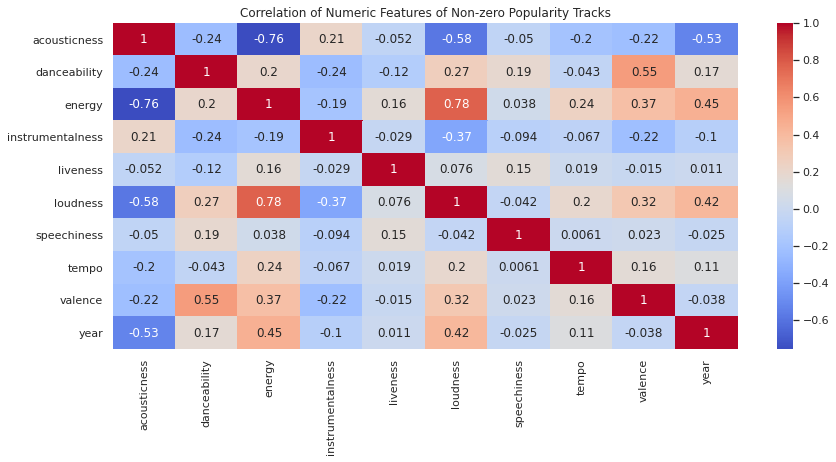

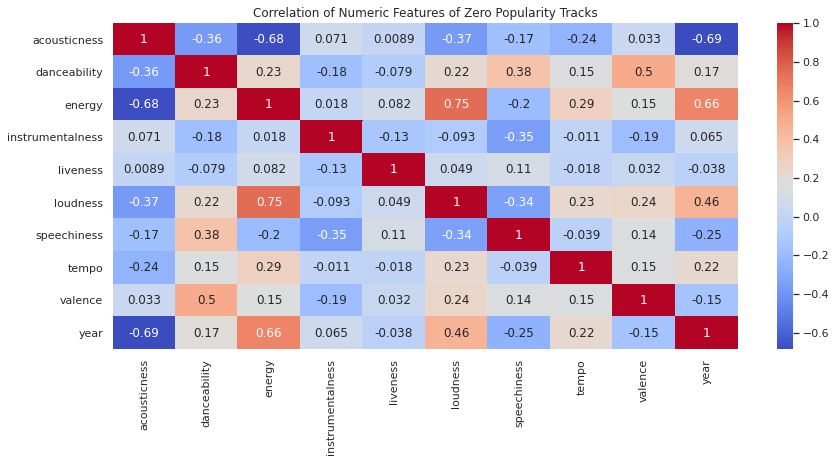

In [ ]:
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")
#corr_nonZeroPop = df_data_noZeroPopularity.corr()
corr_nonZeroPop = df_data_noZeroPopularity.corr()
sns.heatmap(corr_nonZeroPop,annot=True,cmap="coolwarm")
plt.title("Correlation of Numeric Features of Non-zero Popularity Tracks")

plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")
corr_ZeroPop = df_data_onlyZeroPopularity.corr()
sns.heatmap(corr_ZeroPop,annot=True,cmap="coolwarm")
plt.title("Correlation of Numeric Features of Zero Popularity Tracks")

In [ ]:
df_data_noZeroPopularity = df_data_numVarOnly.loc[~(df_data_numVarOnly["popularity"] == 0)]

Using the correlation matrices, it is possible to deduce that many features are similarly correlated for zero and non-zero popularity tracks (acousticness, danceability, loudness and tempo rows). Since the number of tracks between the zero (41k) and non-zero popularity (133k) matrices differ, a total correlation (i.e. zero popularity tracks display total relevance to non-zero popularity tracks) cannot be implied.

---

Distributions of numeric variables are found below:

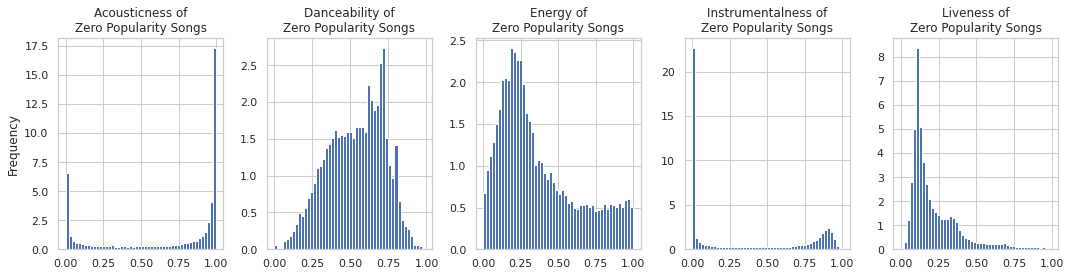

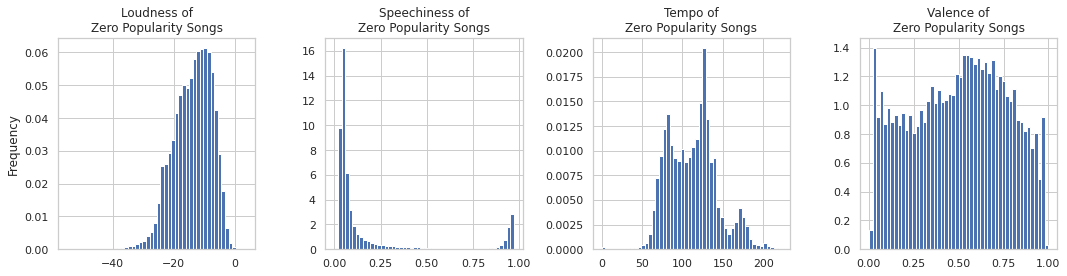

In [ ]:
# numeric_variables = ["acousticness", "danceability", "energy", "instrumentalness"
# ..., "liveness", "loudness", "speechiness", "tempo", "valence", "popularity", "year"]

# Zero popularity tracks
n_bins = 50

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 4))
ax1.set_ylabel("Frequency")
ax1.hist(df_data_onlyZeroPopularity["acousticness"], bins=n_bins, density=True)
ax1.title.set_text("Acousticness of\nZero Popularity Songs")
ax2.hist(df_data_onlyZeroPopularity["danceability"], bins=n_bins, density=True)
ax2.title.set_text("Danceability of\nZero Popularity Songs")
ax3.hist(df_data_onlyZeroPopularity["energy"], bins=n_bins, density=True)
ax3.title.set_text("Energy of\nZero Popularity Songs")
ax4.hist(df_data_onlyZeroPopularity["instrumentalness"], bins=n_bins, density=True)
ax4.title.set_text("Instrumentalness of\nZero Popularity Songs")
ax5.hist(df_data_onlyZeroPopularity["liveness"], bins=n_bins, density=True)
ax5.title.set_text("Liveness of\nZero Popularity Songs")
fig.tight_layout()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))
ax1.set_ylabel("Frequency")
ax1.hist(df_data_onlyZeroPopularity["loudness"], bins=n_bins, density=True)
ax1.title.set_text("Loudness of\nZero Popularity Songs")
ax2.hist(df_data_onlyZeroPopularity["speechiness"], bins=n_bins, density=True)
ax2.title.set_text("Speechiness of\nZero Popularity Songs")
ax3.hist(df_data_onlyZeroPopularity["tempo"], bins=n_bins, density=True)
ax3.title.set_text("Tempo of\nZero Popularity Songs")
ax4.hist(df_data_onlyZeroPopularity["valence"], bins=n_bins, density=True)
ax4.title.set_text("Valence of\nZero Popularity Songs")
fig.tight_layout()

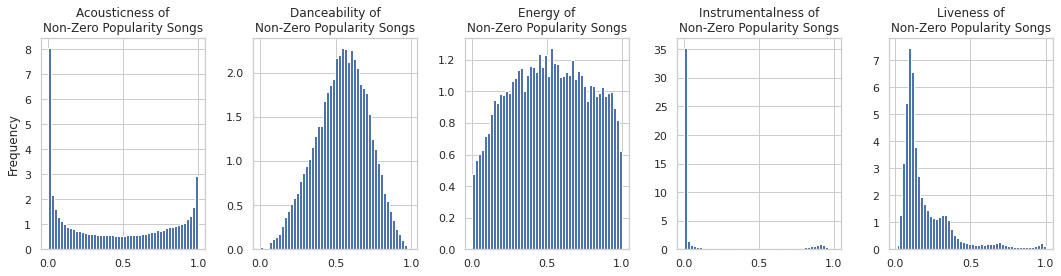

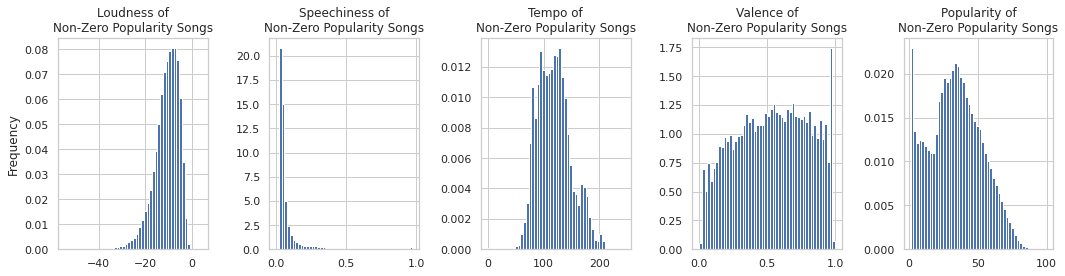

In [ ]:
# Non-zero popularity tracks
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 4))
ax1.set_ylabel("Frequency")
ax1.hist(df_data_noZeroPopularity["acousticness"], bins=n_bins, density=True)
ax1.title.set_text("Acousticness of\nNon-Zero Popularity Songs")
ax2.hist(df_data_noZeroPopularity["danceability"], bins=n_bins, density=True)
ax2.title.set_text("Danceability of\nNon-Zero Popularity Songs")
ax3.hist(df_data_noZeroPopularity["energy"], bins=n_bins, density=True)
ax3.title.set_text("Energy of\nNon-Zero Popularity Songs")
ax4.hist(df_data_noZeroPopularity["instrumentalness"], bins=n_bins, density=True)
ax4.title.set_text("Instrumentalness of\nNon-Zero Popularity Songs")
ax5.hist(df_data_noZeroPopularity["liveness"], bins=n_bins, density=True)
ax5.title.set_text("Liveness of\nNon-Zero Popularity Songs")
fig.tight_layout()

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 4))
ax1.set_ylabel("Frequency")
ax1.hist(df_data_noZeroPopularity["loudness"], bins=n_bins, density=True)
ax1.title.set_text("Loudness of\nNon-Zero Popularity Songs")
ax2.hist(df_data_noZeroPopularity["speechiness"], bins=n_bins, density=True)
ax2.title.set_text("Speechiness of\nNon-Zero Popularity Songs")
ax3.hist(df_data_noZeroPopularity["tempo"], bins=n_bins, density=True)
ax3.title.set_text("Tempo of\nNon-Zero Popularity Songs")
ax4.hist(df_data_noZeroPopularity["valence"], bins=n_bins, density=True)
ax4.title.set_text("Valence of\nNon-Zero Popularity Songs")
ax5.hist(df_data_noZeroPopularity["popularity"], bins=n_bins, density=True)
ax5.title.set_text("Popularity of\nNon-Zero Popularity Songs")
fig.tight_layout()

The distributions of variables are visually similar, pointing to the fact that the popularity variable may be based on specific factors, mainly the timeframe / time of release. Using the non-zero popularity data, it can be observed that the maximum popularity increases as the time of release approaches the latest recorded date.

Text(0, 0.5, 'Popularity')

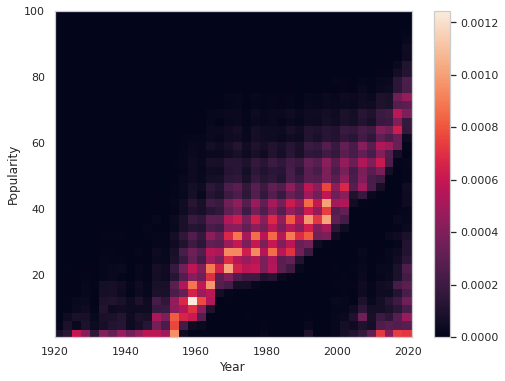

In [ ]:
# Is popularity directly correlated with musicality, or does it have something 
# to do with Spotify's methods of calculation and recommendation?:
plt.figure(figsize=(8, 6))
plt.hist2d(df_data_noZeroPopularity["year"], df_data_noZeroPopularity["popularity"], density = True, bins = 40)
plt.colorbar()
plt.xlabel("Year")
plt.ylabel("Popularity")

Looking at the zero popularity tracks alone, their numbers are populated largely before 1950 and after ~2000. It can be inferred that since the ease of music publication after 2000 increased the number of releases, and pre-rock era songs are not as sought after, zero popularity songs constitute a large number of all releases (nearly 1/3 of the dataset).

Text(0, 0.5, 'Counts')

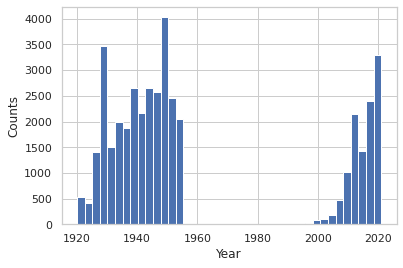

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(df_data_onlyZeroPopularity["year"], bins = 40)
plt.xlabel("Year")
plt.ylabel("Counts")

How does confining the timeframe to post-2000 affect the correlation of variables? It can be understood that post-2000 tracks are more varied and don't follow a general trend in general (year is generally uncorrelated with other variables). Acousticness does not vary as much vs. year (-0.53 in general, -0.023 post-2000), and the mean comes out to be nearly half of the non-zero popularity's.

Post-2000 acousticness mean: 0.25614573978054594.
Post-2000 acousticness mean: 0.44576901266908864.



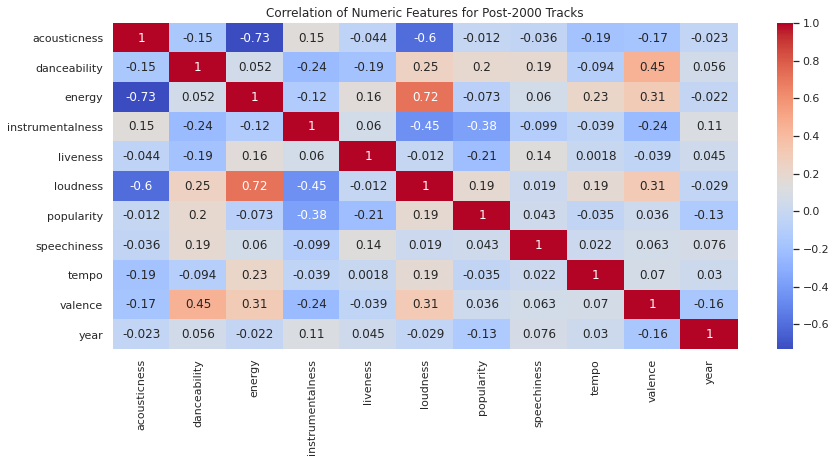

In [ ]:
df_data_revampedDates = df_data_noZeroPopularity.loc[(df_data_noZeroPopularity["year"] >= 2000)]
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")
corr_revampedDates = df_data_revampedDates.corr()
sns.heatmap(corr_revampedDates,annot=True,cmap="coolwarm")
plt.title("Correlation of Numeric Features for Post-2000 Tracks")

print("Post-2000 acousticness mean: " + str(df_data_revampedDates["acousticness"].mean()) + ".")
print("Post-2000 acousticness mean: " + str(df_data_noZeroPopularity["acousticness"].mean()) + ".\n")

There are 36195 unique artists and 137013 unique song names. Top songs' year and tempo distributions are also checked. It is observed that most of the top songs are published very recently.

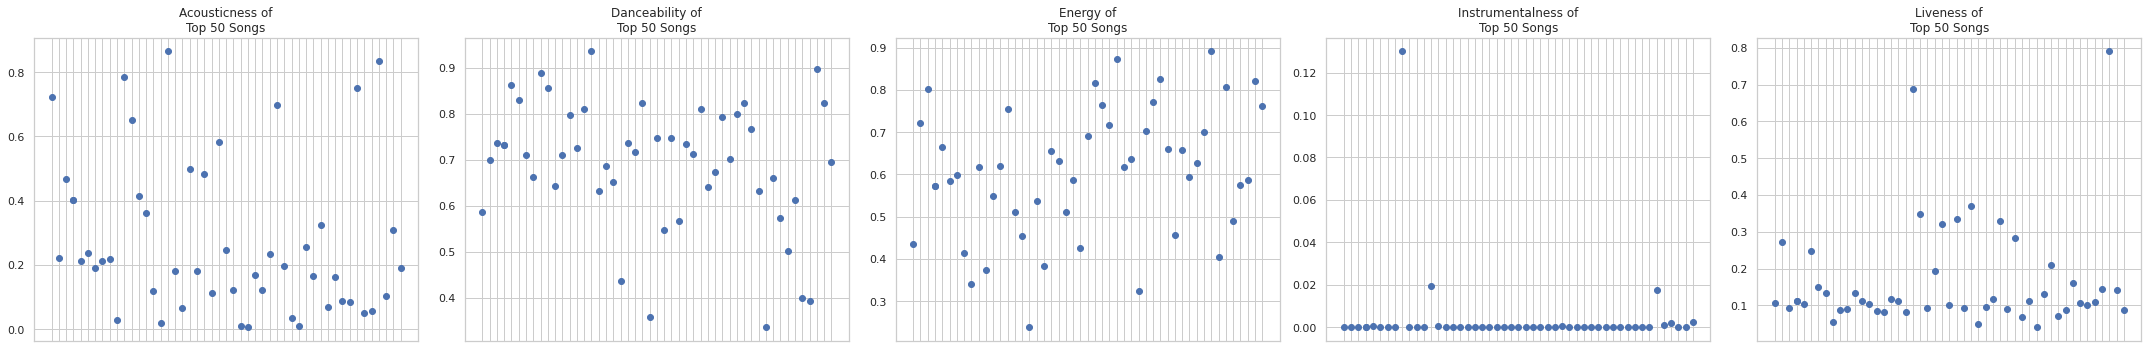

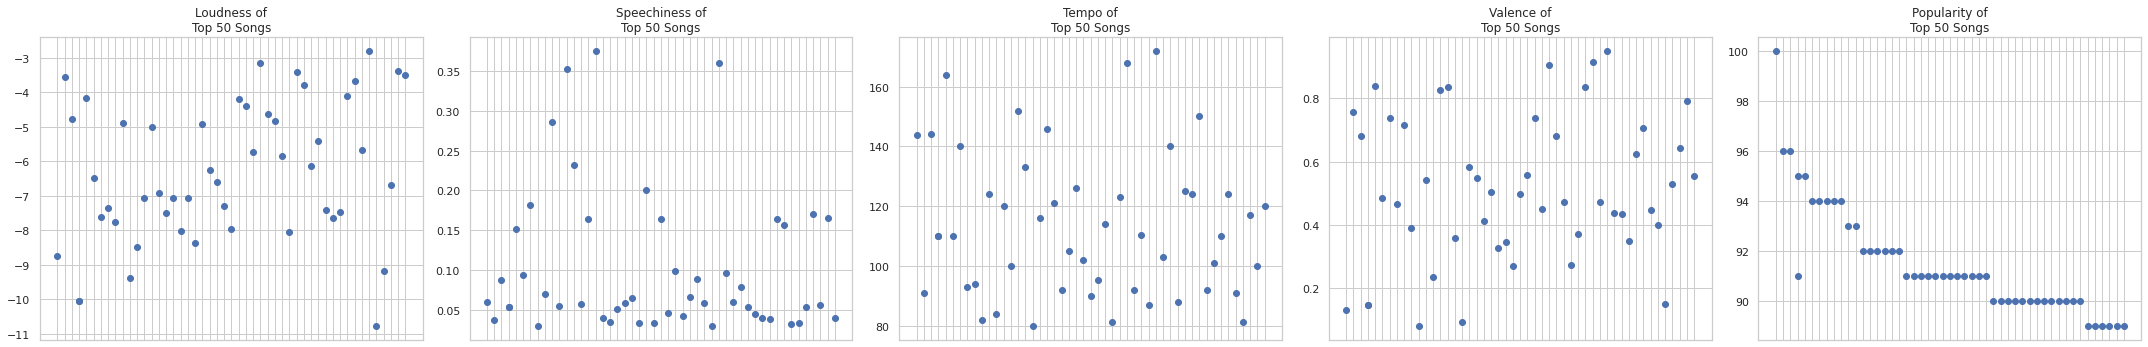

In [ ]:
# Analysis of the most popular artists and songs.
df_data = df

# There are 36195 unique artists.
#print(df_data['artists'].nunique())

# There are 137013 unique song names meaning that they are also not unique
#print(df_data['name'].nunique())

# 50 most popular songs - we cannot use groupby
topsongs= df_data.sort_values(by =["popularity"],inplace=False, ascending=False).head(50)

# 50 most popular artists
# Check artists' dataset
topartists= df_data.groupby("artists")["popularity"].mean().sort_values(ascending=False).head(50)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(30, 5))
ax1.scatter(topsongs["name"], topsongs["acousticness"])
ax1.title.set_text("Acousticness of\nTop 50 Songs")
ax1.tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
ax2.scatter(topsongs["name"], topsongs["danceability"])
ax2.title.set_text("Danceability of\nTop 50 Songs")
ax2.tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
ax3.scatter(topsongs["name"], topsongs["energy"])
ax3.title.set_text("Energy of\nTop 50 Songs")
ax3.tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
ax4.scatter(topsongs["name"], topsongs["instrumentalness"])
ax4.title.set_text("Instrumentalness of\nTop 50 Songs")
ax4.tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
ax5.scatter(topsongs["name"], topsongs["liveness"])
ax5.title.set_text("Liveness of\nTop 50 Songs")
ax5.tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
fig.tight_layout()

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(30, 5))
ax1.scatter(topsongs["name"], topsongs["loudness"])
ax1.title.set_text("Loudness of\nTop 50 Songs")
ax1.tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
ax2.scatter(topsongs["name"], topsongs["speechiness"])
ax2.title.set_text("Speechiness of\nTop 50 Songs")
ax2.tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
ax3.scatter(topsongs["name"], topsongs["tempo"])
ax3.title.set_text("Tempo of\nTop 50 Songs")
ax3.tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
ax4.scatter(topsongs["name"], topsongs["valence"])
ax4.title.set_text("Valence of\nTop 50 Songs")
ax4.tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
ax5.scatter(topsongs["name"], topsongs["popularity"])
ax5.title.set_text("Popularity of\nTop 50 Songs")
ax5.tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
fig.tight_layout()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


'\n#top songs popularity barplot\nplt.figure(figsize=(10,6))\nplot1 = sns.barplot(topartists["name"],topartists["popularity"])\nplt.xticks(rotation=90)\nplot1.set_title("Top Songs")\nplot1.set_xlabel("Songs")\nplot1.set_ylabel("Popularity")\n'

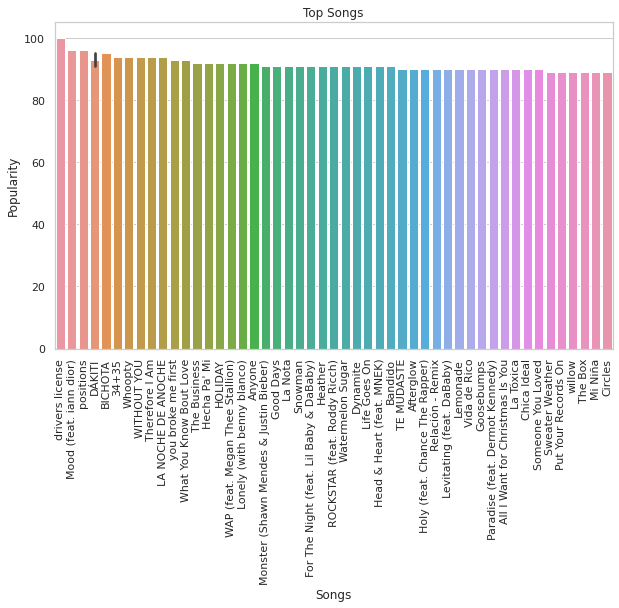

In [ ]:
topsongs= df_data.sort_values(by =["popularity"],inplace=False, ascending=False).head(50)


#50 most popular artists
#check artists dataset
topartists= df_data.groupby("artists")["popularity"].mean().sort_values(ascending=False).head(50)



#top songs popularity barplot
plt.figure(figsize=(10,6))
plot1 = sns.barplot(topsongs["name"],topsongs["popularity"])
plt.xticks(rotation=90)
plot1.set_title("Top Songs")
plot1.set_xlabel("Songs")
plot1.set_ylabel("Popularity")

'''
#top songs popularity barplot
plt.figure(figsize=(10,6))
plot1 = sns.barplot(topartists["name"],topartists["popularity"])
plt.xticks(rotation=90)
plot1.set_title("Top Songs")
plot1.set_xlabel("Songs")
plot1.set_ylabel("Popularity")
'''

It can be observed that the hit songs (based on popularity) operate on some common bases - high energy and tempo, minimally instrumental / maximally vocal studio releases (low liveness parameter).

### **2.2. Genre Reduction and Classification**





It has been observed that there is a significant number of genres, many of which are subgenres. Below indicates the first 10 rows of the new data used in the following section. 

In [ ]:
fname = "data_by_genres.csv"
df_data_genres = pd.read_csv(join(path_prefix, folder, fname))

df_data_genres.head(10)

,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode
0,21st century classical,0.754600,0.284100,3.525932e+05,0.159580,0.484374,0.168580,-22.153400,0.062060,91.351000,0.143380,6.600000,4,1
1,432hz,0.485515,0.312000,1.047430e+06,0.391678,0.477250,0.265940,-18.131267,0.071717,118.900933,0.236483,41.200000,11,1
2,8-bit,0.028900,0.673000,1.334540e+05,0.950000,0.630000,0.069000,-7.899000,0.292000,192.816000,0.997000,0.000000,5,1
3,[],0.535793,0.546937,2.495312e+05,0.485430,0.278442,0.220970,-11.624754,0.101511,116.068980,0.486361,12.350770,7,1
4,a cappella,0.694276,0.516172,2.018391e+05,0.330533,0.036080,0.222983,-12.656547,0.083627,105.506031,0.454077,39.086248,7,1
5,abstract,0.411262,0.473600,3.660984e+05,0.479400,0.841400,0.097160,-15.799400,0.045300,142.495400,0.274260,43.800000,5,1
6,abstract beats,0.459000,0.669000,1.748670e+05,0.735000,0.000000,0.103000,-7.264000,0.329000,117.284000,0.723000,62.000000,10,1
7,abstract hip hop,0.297353,0.725274,2.282049e+05,0.726844,0.099187,0.268938,-7.257105,0.224437,107.588773,0.639051,21.050866,1,1
8,abstract idm,0.995000,0.174000,5.805330e+05,0.002910,0.931000,0.098300,-37.518000,0.039900,67.560000,0.032800,46.000000,0,1
9,accordeon,0.598750,0.442000,1.654800e+05,0.314000,0.607000,0.191675,-12.174250,0.042475,139.819500,0.511500,35.250000,2,1


Since there are some missing values of genres as can be seen with the indicator [], they have been changed to label '0' to visualize them in the following part.

In [ ]:
df_data_genres["genres"][df_data_genres["genres"] == "[]"] = np.nan
df_data_genres["genres"] = df_data_genres["genres"].fillna('0')
df_data_genres

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode
0,21st century classical,0.754600,0.284100,3.525932e+05,0.159580,0.484374,0.168580,-22.153400,0.062060,91.351000,0.143380,6.600000,4,1
1,432hz,0.485515,0.312000,1.047430e+06,0.391678,0.477250,0.265940,-18.131267,0.071717,118.900933,0.236483,41.200000,11,1
2,8-bit,0.028900,0.673000,1.334540e+05,0.950000,0.630000,0.069000,-7.899000,0.292000,192.816000,0.997000,0.000000,5,1
3,0,0.535793,0.546937,2.495312e+05,0.485430,0.278442,0.220970,-11.624754,0.101511,116.068980,0.486361,12.350770,7,1
4,a cappella,0.694276,0.516172,2.018391e+05,0.330533,0.036080,0.222983,-12.656547,0.083627,105.506031,0.454077,39.086248,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3227,zim urban groove,0.003910,0.553000,4.267200e+04,0.942000,0.961000,0.113000,-8.004000,0.039900,134.995000,0.752000,9.000000,7,1
3228,zolo,0.208648,0.533837,2.641016e+05,0.620470,0.163334,0.201430,-10.878906,0.061828,126.765194,0.576721,31.108254,9,1
3229,zouk,0.272928,0.641889,4.416418e+05,0.695778,0.257604,0.166011,-9.518889,0.050511,105.848889,0.878444,32.555556,7,1
3230,zurich indie,0.993000,0.705667,1.984173e+05,0.172667,0.468633,0.179667,-11.453333,0.348667,91.278000,0.739000,0.000000,7,0


From [Spotify's official Web API reference](https://developer.spotify.com/documentation/web-api/reference/#objects-index), the popularity metric is defined as follows:

"The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, **on the total number of plays the track has had and how recent those plays are**.
Generally speaking, **songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past** [...]"

This mirrors the results above, as the popularity per track tends towards 100 as time progresses and older songs are less popular overall.

As seen below, the most popular songs are in subgenres, describing the track itself. For instance, the most popular song genres are 'Chinese Electropop', 'Korean Mask Singer' and 'Yaoi'. When the the number of occurrences of these genres in the data frame is investigated, they are unique. 

                 genres  acousticness  danceability  ...  popularity  key  mode
565  chinese electropop       0.00257          0.66  ...        79.0    1     0

[1 rows x 14 columns]
                  genres  acousticness  danceability  ...  popularity  key  mode
1768  korean mask singer         0.238         0.658  ...        78.0    9     0

[1 rows x 14 columns]
     genres  acousticness  danceability  ...  popularity  key  mode
3213   yaoi       0.00655         0.603  ...        77.0    8     0

[1 rows x 14 columns]


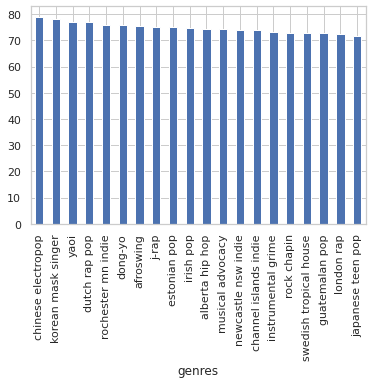

In [ ]:
most_popular_genres = df_data_genres.groupby(by = 'genres').mean()['popularity'].sort_values(ascending=False).head(20)
most_popular_genres.plot.bar(grid = True)

print(df_data_genres[df_data_genres.genres == 'chinese electropop'])
print(df_data_genres[df_data_genres.genres == 'korean mask singer'])
print(df_data_genres[df_data_genres.genres == 'yaoi'])

To solve the issues mentioned above, and for the purpose of simplicity, the genres are classified to main 15 + 1 (other) categories. Since the 'Other' category consists of songs from many different genres which are not from any classified category, it does not provide an accurate information to comment on.

However, the most popular genres according to the main categories can be observed below. The new classification is also added to the data frame.

In [ ]:
def genre_classifier(genres):

  #print(genre)

  if genres.lower().find("country") != -1:
    return "Country"

  elif genres.lower().find("acoustic") != -1:
    return "Acoustic"
  
  elif genres.lower().find("electronic") != -1:
    return "Electronic"

  elif genres.lower().find("techno") != -1:
    return "Techno"

  elif genres.lower().find("classic") != -1:
    return "Classical"
    
  elif genres.lower().find("hip hop") != -1:
    return "Hip-Hop"

  elif genres.lower().find("indie") != -1:
    return "Indie"
  
  elif genres.lower().find("jazz") != -1:
    return "Jazz"
  
  elif genres.lower().find("k pop") != -1:
    return "K-Pop"

  elif genres.lower().find("metal") != -1:
    return "Metal"

  elif genres.lower().find("oldies") != -1:
    return "Oldies"
  
  elif genres.lower().find("pop") != -1:
    return "Pop"
  
  elif genres.lower().find("rap") != -1:
    return "Rap"

  elif (genres.lower().find("rhythm") and genres.lower().find("blues")) != -1:
    return "R&B"

  elif genres.lower().find("rock") != -1:
    return "Rock"

  elif genres.find('0') != -1:
    return "0"

  else:
    return "Other"
  
df_data_genres["Classified Genres"] = df_data_genres['genres'].apply(genre_classifier)  # resulting series will be stored in a new column
df_data_genres.head(20)

,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,Classified Genres
0,21st century classical,0.754600,0.284100,3.525932e+05,0.159580,0.484374,0.168580,-22.153400,0.062060,91.351000,0.143380,6.600000,4,1,Classical
1,432hz,0.485515,0.312000,1.047430e+06,0.391678,0.477250,0.265940,-18.131267,0.071717,118.900933,0.236483,41.200000,11,1,Other
2,8-bit,0.028900,0.673000,1.334540e+05,0.950000,0.630000,0.069000,-7.899000,0.292000,192.816000,0.997000,0.000000,5,1,Other
3,0,0.535793,0.546937,2.495312e+05,0.485430,0.278442,0.220970,-11.624754,0.101511,116.068980,0.486361,12.350770,7,1,0
4,a cappella,0.694276,0.516172,2.018391e+05,0.330533,0.036080,0.222983,-12.656547,0.083627,105.506031,0.454077,39.086248,7,1,Other
5,abstract,0.411262,0.473600,3.660984e+05,0.479400,0.841400,0.097160,-15.799400,0.045300,142.495400,0.274260,43.800000,5,1,Other
6,abstract beats,0.459000,0.669000,1.748670e+05,0.735000,0.000000,0.103000,-7.264000,0.329000,117.284000,0.723000,62.000000,10,1,Other
7,abstract hip hop,0.297353,0.725274,2.282049e+05,0.726844,0.099187,0.268938,-7.257105,0.224437,107.588773,0.639051,21.050866,1,1,Hip-Hop
8,abstract idm,0.995000,0.174000,5.805330e+05,0.002910,0.931000,0.098300,-37.518000,0.039900,67.560000,0.032800,46.000000,0,1,Other
9,accordeon,0.598750,0.442000,1.654800e+05,0.314000,0.607000,0.191675,-12.174250,0.042475,139.819500,0.511500,35.250000,2,1,Other


Additionally, for the new extracted categories, the centerality metrics are observed. As seen below in terms of mean and median metrics, popularity of the classified genres differ slightly. However, in both cases the most popular genre is Rap in terms of mean and median.

Text(0, 0.5, 'Average Popularity')

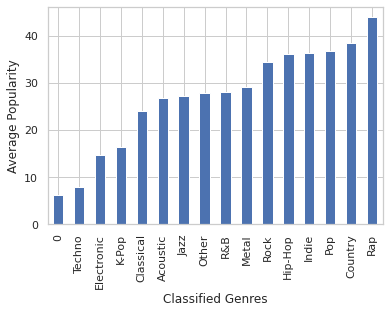

In [ ]:
df_data_genres.groupby(by = 'Classified Genres').mean()['popularity'].sort_values(ascending=True).plot.bar(grid = True)
plt.ylabel("Average Popularity")

Since there are a lot of genre with 0 poularity which does not provide any useful information for comparison or contrast and any benefit for the continium of the project, the mean distribution also observed by looking at the genres with extracting 0 popularity songs.

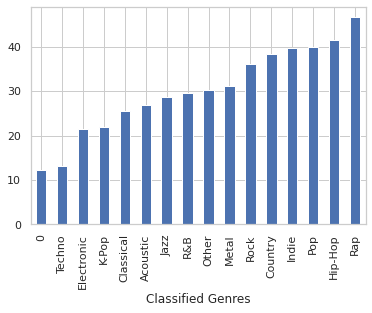

In [ ]:
df_data_genres_extracted_0_popularity = df_data_genres[df_data_genres["popularity"]  !=0]
df_data_genres_extracted_0_popularity.groupby(by = 'Classified Genres').mean()['popularity'].sort_values(ascending=True).plot.bar(grid = True)

Text(0, 0.5, 'Median of Popularity')

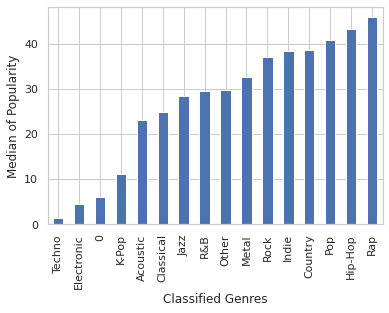

In [ ]:
df_data_genres.groupby(by = 'Classified Genres').median()['popularity'].sort_values(ascending=True).plot.bar(grid = True)
plt.ylabel("Median of Popularity")

Addtionaly how the popularity of genres differ are observed below according to the standard deviation metric. It can be interpreted as the genres have a significant variance in terms of popularity between genres.

Text(0, 0.5, 'Standard Variation of Popularity')

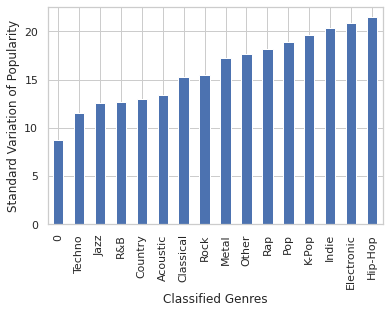

In [ ]:
df_data_genres.groupby(by = 'Classified Genres').std()['popularity'].sort_values(ascending=True).plot.bar(grid = True)
plt.ylabel("Standard Variation of Popularity")

## **3. Temporal Analysis of the Genres**

In [ ]:
import pandas as pd
import numpy as np
import re

folder = "CS 210 - Project/"

data = pd.read_csv(join(path_prefix, folder,"data.csv"))
genre = pd.read_csv(join(path_prefix, folder,"data_w_genres.csv"))

In [ ]:
data.tail()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
174384,0.00917,"['DJ Combo', 'Sander-7', 'Tony T']",0.792,147615,0.866,0,46LhBf6TvYjZU2SMvGZAbn,0.00006,6,0.178,-5.089,0,The One,0,2020-12-25,0.0356,125.972,0.186,2020
174385,0.79500,['Alessia Cara'],0.429,144720,0.211,0,7tue2Wemjd0FZzRtDrQFZd,0.00000,4,0.196,-11.665,1,A Little More,0,2021-01-22,0.0360,94.710,0.228,2021
174386,0.80600,['Roger Fly'],0.671,218147,0.589,0,48Qj61hOdYmUCFJbpQ29Ob,0.92000,4,0.113,-12.393,0,Together,0,2020-12-09,0.0282,108.058,0.714,2020
174387,0.92000,['Taylor Swift'],0.462,244000,0.240,1,1gcyHQpBQ1lfXGdhZmWrHP,0.00000,0,0.113,-12.077,1,champagne problems,69,2021-01-07,0.0377,171.319,0.320,2021
174388,0.23900,['Roger Fly'],0.677,197710,0.460,0,57tgYkWQTNHVFEt6xDKKZj,0.89100,7,0.215,-12.237,1,Improvisations,0,2020-12-09,0.0258,112.208,0.747,2020


In [ ]:
data['artists'] = data['artists'].apply(lambda x: re.findall(r'[\']([\w\s-]+)[\']', x))
data.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,[Mamie Smith],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,[],0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,[Mamie Smith],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,[Oscar Velazquez],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,[Mixe],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


In [ ]:
data = data.explode('artists')
data.tail()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
174384,0.00917,Tony T,0.792,147615,0.866,0,46LhBf6TvYjZU2SMvGZAbn,0.00006,6,0.178,-5.089,0,The One,0,2020-12-25,0.0356,125.972,0.186,2020
174385,0.79500,Alessia Cara,0.429,144720,0.211,0,7tue2Wemjd0FZzRtDrQFZd,0.00000,4,0.196,-11.665,1,A Little More,0,2021-01-22,0.0360,94.710,0.228,2021
174386,0.80600,Roger Fly,0.671,218147,0.589,0,48Qj61hOdYmUCFJbpQ29Ob,0.92000,4,0.113,-12.393,0,Together,0,2020-12-09,0.0282,108.058,0.714,2020
174387,0.92000,Taylor Swift,0.462,244000,0.240,1,1gcyHQpBQ1lfXGdhZmWrHP,0.00000,0,0.113,-12.077,1,champagne problems,69,2021-01-07,0.0377,171.319,0.320,2021
174388,0.23900,Roger Fly,0.677,197710,0.460,0,57tgYkWQTNHVFEt6xDKKZj,0.89100,7,0.215,-12.237,1,Improvisations,0,2020-12-09,0.0258,112.208,0.747,2020


In [ ]:
data.head(5)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,Mamie Smith,0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,NaN,0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,Mamie Smith,0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,Oscar Velazquez,0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,Mixe,0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


In [ ]:
merged = pd.merge(data, genre, on="artists")
merged.tail()

,acousticness_x,artists,danceability_x,duration_ms_x,energy_x,explicit,id,instrumentalness_x,key_x,liveness_x,loudness_x,mode_x,name,popularity_x,release_date,speechiness_x,tempo_x,valence_x,year,acousticness_y,danceability_y,duration_ms_y,energy_y,instrumentalness_y,liveness_y,loudness_y,speechiness_y,tempo_y,valence_y,popularity_y,key_y,mode_y,count,genres
218698,0.966,Johannes Bornlöf,0.269,424200,0.0926,0,1Svqb7CX6rQvJpZY3iVBXh,0.890,9,0.0992,-24.280,0,Divenire,0,2021-01-23,0.0609,120.323,0.1020,2021,0.978857,0.303,358997.571429,0.071614,0.889143,0.104214,-26.142143,0.055614,120.350429,0.095443,0.0,9,0,14,"['background music', 'calming instrumental', '..."
218699,0.995,Johannes Bornlöf,0.297,349200,0.0287,0,2LeqqwzobL5ktfQhWA3bHh,0.908,8,0.0995,-30.008,1,Nuvole bianche,0,2021-01-23,0.0564,141.636,0.0678,2021,0.978857,0.303,358997.571429,0.071614,0.889143,0.104214,-26.142143,0.055614,120.350429,0.095443,0.0,9,0,14,"['background music', 'calming instrumental', '..."
218700,0.995,Johannes Bornlöf,0.343,206700,0.0165,0,3Glmyv3hbGGTgeR3FZrxJA,0.878,9,0.0774,-30.915,0,Una Mattina,0,2021-01-23,0.0455,126.970,0.1510,2021,0.978857,0.303,358997.571429,0.071614,0.889143,0.104214,-26.142143,0.055614,120.350429,0.095443,0.0,9,0,14,"['background music', 'calming instrumental', '..."
218701,0.966,Johannes Bornlöf,0.269,424200,0.0926,0,4yBReaKJW78ZYCHpc1cfaK,0.890,9,0.0992,-24.280,0,Divenire,0,2021-01-23,0.0609,120.323,0.1020,2021,0.978857,0.303,358997.571429,0.071614,0.889143,0.104214,-26.142143,0.055614,120.350429,0.095443,0.0,9,0,14,"['background music', 'calming instrumental', '..."
218702,0.988,Johannes Bornlöf,0.316,303333,0.0573,0,6QGVWUbmlePAiY5zJjfCmT,0.879,3,0.1200,-24.121,1,Night,0,2021-01-23,0.0515,81.070,0.0373,2021,0.978857,0.303,358997.571429,0.071614,0.889143,0.104214,-26.142143,0.055614,120.350429,0.095443,0.0,9,0,14,"['background music', 'calming instrumental', '..."


In [ ]:
merged["Classified Genres"] = merged['genres'].apply(genre_classifier)  # resulting series will be stored in a new column

In [ ]:
merged.head(50)

,acousticness_x,artists,danceability_x,duration_ms_x,energy_x,explicit,id,instrumentalness_x,key_x,liveness_x,loudness_x,mode_x,name,popularity_x,release_date,speechiness_x,tempo_x,valence_x,year,acousticness_y,danceability_y,duration_ms_y,energy_y,instrumentalness_y,liveness_y,loudness_y,speechiness_y,tempo_y,valence_y,popularity_y,key_y,mode_y,count,genres,Classified Genres
0,0.991000,Mamie Smith,0.598,168333,0.2240,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920,0.983000,0.627250,177981.750000,0.184556,0.000288,0.372625,-12.800313,0.121438,113.009938,0.641062,3.187500,0,1,16,"['harlem renaissance', 'traditional blues']",R&B
1,0.993000,Mamie Smith,0.647,163827,0.1860,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920,0.983000,0.627250,177981.750000,0.184556,0.000288,0.372625,-12.800313,0.121438,113.009938,0.641062,3.187500,0,1,16,"['harlem renaissance', 'traditional blues']",R&B
2,0.992000,Mamie Smith,0.782,195200,0.0573,0,5DlCyqLyX2AOVDTjjkDZ8x,0.000002,5,0.1760,-12.453,1,Don't You Advertise Your Man,5,1920,0.0592,85.652,0.4870,1920,0.983000,0.627250,177981.750000,0.184556,0.000288,0.372625,-12.800313,0.121438,113.009938,0.641062,3.187500,0,1,16,"['harlem renaissance', 'traditional blues']",R&B
3,0.995000,Mamie Smith,0.482,198000,0.2290,0,0lqEx4vktZP1y9hnwfF27Y,0.000061,7,0.5490,-12.619,1,Kansas City Man Blues - 78rpm Version,4,1920,0.0812,77.232,0.4610,1920,0.983000,0.627250,177981.750000,0.184556,0.000288,0.372625,-12.800313,0.121438,113.009938,0.641062,3.187500,0,1,16,"['harlem renaissance', 'traditional blues']",R&B
4,0.992000,Mamie Smith,0.574,189800,0.1380,0,4HYmmG8uHL2hP4zSFWavKF,0.000492,3,0.2330,-14.171,1,Miss Jenny's Ball (aka There'll Be No Freebies...,1,1920,0.1090,158.422,0.7640,1920,0.983000,0.627250,177981.750000,0.184556,0.000288,0.372625,-12.800313,0.121438,113.009938,0.641062,3.187500,0,1,16,"['harlem renaissance', 'traditional blues']",R&B
5,0.977000,Mamie Smith,0.594,167440,0.2400,0,5Dh1E4kXDwXwVfChsExG3G,0.000000,0,0.5030,-12.009,1,The Lure Of The South,0,1920,0.0927,75.003,0.7550,1920,0.983000,0.627250,177981.750000,0.184556,0.000288,0.372625,-12.800313,0.121438,113.009938,0.641062,3.187500,0,1,16,"['harlem renaissance', 'traditional blues']",R&B
6,0.995000,Mamie Smith,0.600,185840,0.0753,0,67WjqZ50Q9WmLMW62qfDdL,0.002470,7,0.2290,-14.842,0,Do It Mr. So-And-So,1,1920,0.1990,206.951,0.4900,1920,0.983000,0.627250,177981.750000,0.184556,0.000288,0.372625,-12.800313,0.121438,113.009938,0.641062,3.187500,0,1,16,"['harlem renaissance', 'traditional blues']",R&B
7,0.986000,Mamie Smith,0.607,178067,0.2840,0,7FZnWeEpRXMXXUiynwQKso,0.000003,0,0.4910,-11.124,0,My Sportin' Man,0,1920,0.2120,114.267,0.5760,1920,0.983000,0.627250,177981.750000,0.184556,0.000288,0.372625,-12.800313,0.121438,113.009938,0.641062,3.187500,0,1,16,"['harlem renaissance', 'traditional blues']",R&B
8,0.938000,Mamie Smith,0.675,169267,0.1950,0,3n4ojCBgHcvMNYXIvWhWL2,0.000000,0,0.2910,-14.189,1,The Lure of the South - Live,1,1927,0.0909,81.068,0.7480,1927,0.983000,0.627250,177981.750000,0.184556,0.000288,0.372625,-12.800313,0.121438,113.009938,0.641062,3.187500,0,1,16,"['harlem renaissance', 'traditional blues']",R&B
9,0.000173,Oscar Velazquez,0.730,422087,0.7980,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920,0.000445,0.653333,407315.000000,0.821000,0.856667,0.086300,-7.745667,0.048400,128.659667,0.120400,11.000000,2,1,6,['circuit'],Other


For the sake of exploration, one main genre is selected for further analysis:

In [ ]:
# Rock kategorisinin yıllara göre dağılım grafiğini koymayı unutma

In [ ]:
merged_numeric_var = ["acousticness_x", "danceability_x", "energy_x", "instrumentalness_x", 
                     "liveness_x", "loudness_x", "speechiness_x", "tempo_x", "valence_x", "popularity_x", "year"]
merged_all_var = merged.columns

In [ ]:
merged_rock = merged.loc[merged["Classified Genres"] == "Rock"]

for var in merged_all_var:
   if var not in merged_numeric_var:
      del merged_rock[var]

In [ ]:
merged_rock.head()

,acousticness_x,danceability_x,energy_x,instrumentalness_x,liveness_x,loudness_x,popularity_x,speechiness_x,tempo_x,valence_x,year
28583,0.33800,0.332,0.790,0.000151,0.147,-11.023,13,0.0752,156.875,0.644,1934
28584,0.25600,0.511,0.464,0.000004,0.132,-10.765,60,0.0383,123.412,0.289,1985
28585,0.58200,0.271,0.551,0.000042,0.256,-7.480,78,0.0457,78.111,0.428,1988
28586,0.00595,0.539,0.919,0.000002,0.108,-7.359,15,0.0624,125.420,0.773,2013
28587,0.01730,0.550,0.745,0.000000,0.228,-6.543,11,0.0350,143.245,0.912,2013


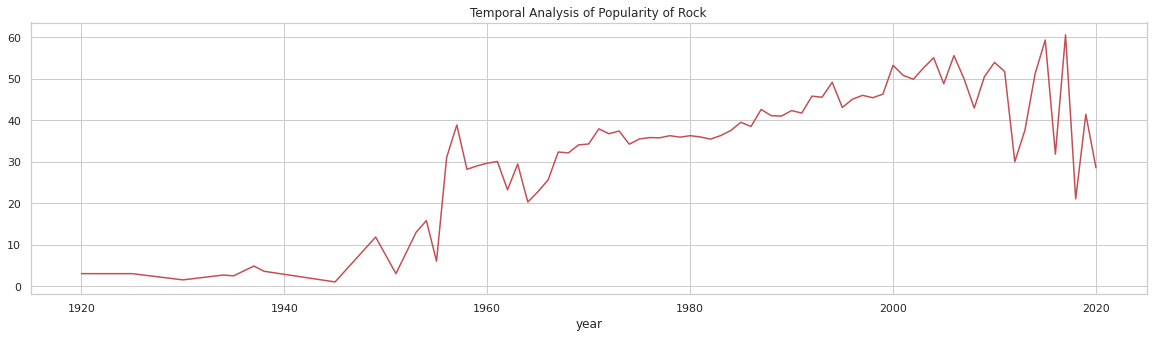

In [ ]:
merged_rock_temporal = merged_rock

merged_rock_temporal = merged_rock_temporal[merged_rock_temporal["popularity_x"]  !=0]

merged_rock_temporal = merged_rock_temporal.sort_values(by = ["popularity_x"] , inplace=False, ascending=True).groupby(by = 'year').mean()['popularity_x']

merged_rock_temporal.plot(grid = True, figsize=(20,5), title = "Temporal Analysis of Popularity of Rock", color = 'r')

As it can be seen from as one example of genre for Rock, in general with some ups and downs the graphic therefore the popularity is seemed to increase with years.

## **4. Statistical Analysis & Hypothesis Testing**

### **4.1. Statistical Analysis of Tracks Based on Popularity**


#### **4.1.1. Features' Contribution to Popularity of Songs**

From the visualizations of acoustic variables' frequencies between zero and non-zero popularity tracks, it can be observed that the distributions of danceability, energy, loudness, tempo, liveness and valence can be modelled as Gaussian curves using the central limit theorem.

By comparing the mentioned features above, contribution of acoustic variables on popularity can be inferred, even though the popularity metric seems that it is heavily based on the release date and how many times the track has been played repeateadly. To minimize the time bias, the dataframe is limited to post-2000 tracks afterwards.

In [ ]:
n_bins = 50

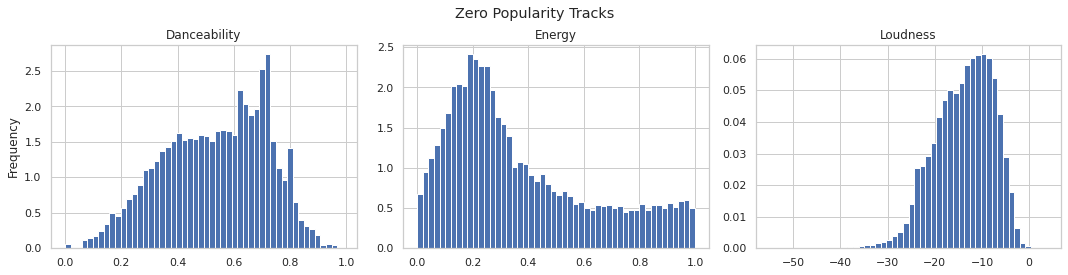

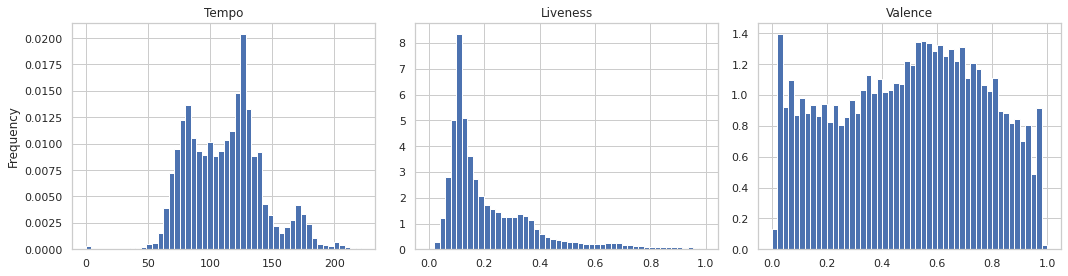

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig_title = fig.suptitle("Zero Popularity Tracks")
ax1.set_ylabel("Frequency")
ax1.hist(df_data_onlyZeroPopularity["danceability"], bins=n_bins, density=True)
ax1.title.set_text("Danceability")
ax2.hist(df_data_onlyZeroPopularity["energy"], bins=n_bins, density=True)
ax2.title.set_text("Energy")
ax3.hist(df_data_onlyZeroPopularity["loudness"], bins=n_bins, density=True)
ax3.title.set_text("Loudness")
fig.tight_layout()

fig_title.set_y(0.95)
fig.subplots_adjust(top=0.82)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.set_ylabel("Frequency")
ax1.hist(df_data_onlyZeroPopularity["tempo"], bins=n_bins, density=True)
ax1.title.set_text("Tempo")
ax2.hist(df_data_onlyZeroPopularity["liveness"], bins=n_bins, density=True)
ax2.title.set_text("Liveness")
ax3.hist(df_data_onlyZeroPopularity["valence"], bins=n_bins, density=True)
ax3.title.set_text("Valence")
fig.tight_layout()

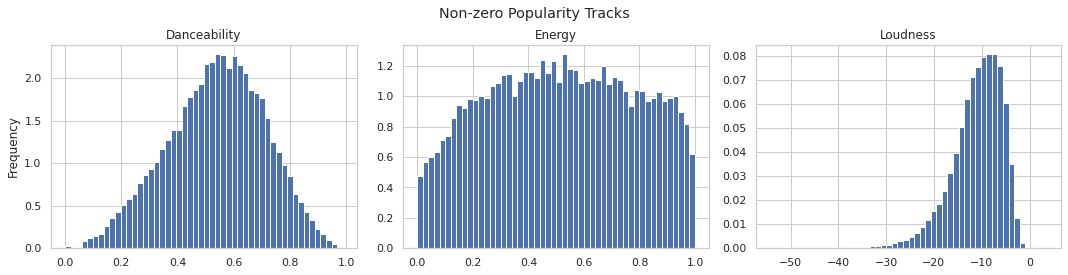

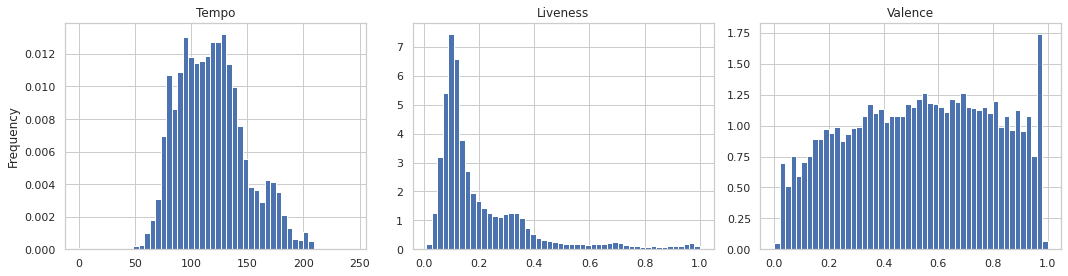

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig_title = fig.suptitle("Non-zero Popularity Tracks")
ax1.set_ylabel("Frequency")
ax1.hist(df_data_noZeroPopularity["danceability"], bins=n_bins, density=True)
ax1.title.set_text("Danceability")
ax2.hist(df_data_noZeroPopularity["energy"], bins=n_bins, density=True)
ax2.title.set_text("Energy")
ax3.hist(df_data_noZeroPopularity["loudness"], bins=n_bins, density=True)
ax3.title.set_text("Loudness")
fig.tight_layout()

fig_title.set_y(0.95)
fig.subplots_adjust(top=0.82)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.set_ylabel("Frequency")
ax1.hist(df_data_noZeroPopularity["tempo"], bins=n_bins, density=True)
ax1.title.set_text("Tempo")
ax2.hist(df_data_noZeroPopularity["liveness"], bins=n_bins, density=True)
ax2.title.set_text("Liveness")
ax3.hist(df_data_noZeroPopularity["valence"], bins=n_bins, density=True)
ax3.title.set_text("Valence")
fig.tight_layout()

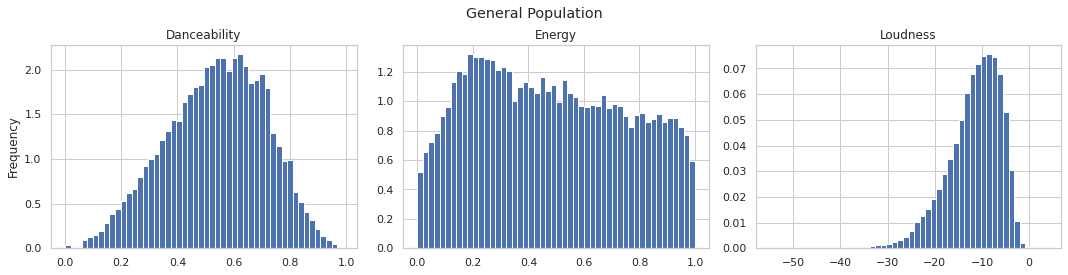

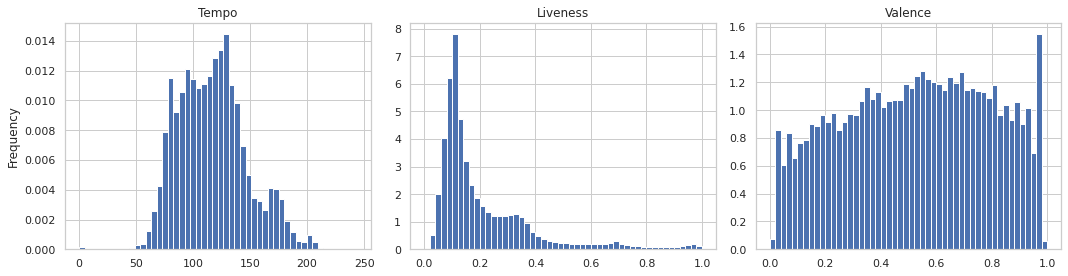

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig_title = fig.suptitle("General Population")
ax1.set_ylabel("Frequency")
ax1.hist(df_data_numVarOnly["danceability"], bins=n_bins, density=True)
ax1.title.set_text("Danceability")
ax2.hist(df_data_numVarOnly["energy"], bins=n_bins, density=True)
ax2.title.set_text("Energy")
ax3.hist(df_data_numVarOnly["loudness"], bins=n_bins, density=True)
ax3.title.set_text("Loudness")
fig.tight_layout()

fig_title.set_y(0.95)
fig.subplots_adjust(top=0.82)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.set_ylabel("Frequency")
ax1.hist(df_data_numVarOnly["tempo"], bins=n_bins, density=True)
ax1.title.set_text("Tempo")
ax2.hist(df_data_numVarOnly["liveness"], bins=n_bins, density=True)
ax2.title.set_text("Liveness")
ax3.hist(df_data_numVarOnly["valence"], bins=n_bins, density=True)
ax3.title.set_text("Valence")
fig.tight_layout()

Overlaying zero and non-zero popularity distributions of above variables using `sns.kdeplot`.

In [ ]:
smooth_param = 3

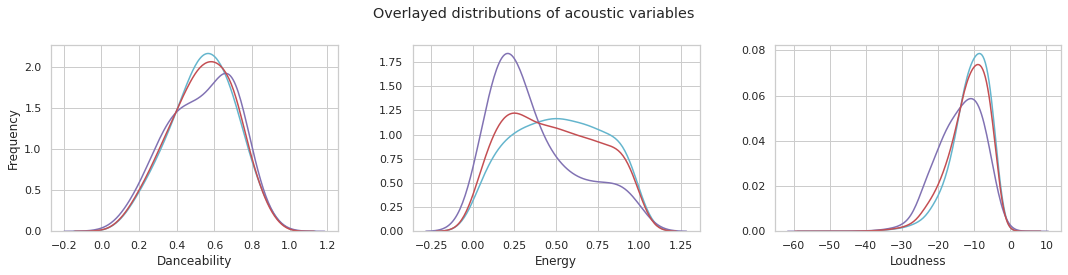

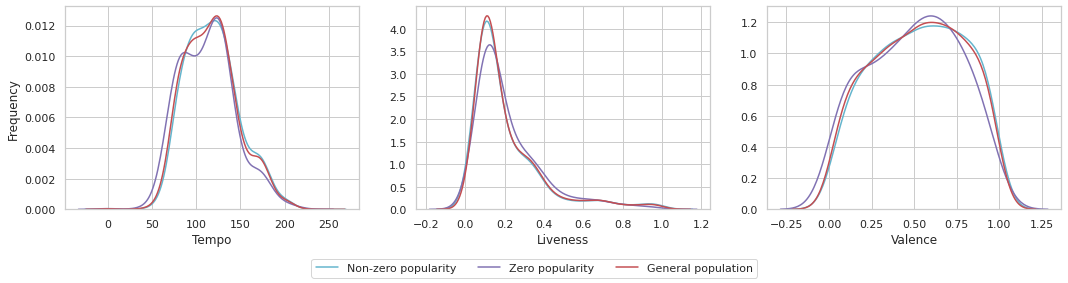

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig_title = fig.suptitle("Overlayed distributions of acoustic variables")
sns.kdeplot(df_data_noZeroPopularity["danceability"], ax=ax1, color='c', bw_adjust=smooth_param)
sns.kdeplot(df_data_onlyZeroPopularity["danceability"], ax=ax1, color='m', bw_adjust=smooth_param)
sns.kdeplot(df_data_numVarOnly["danceability"], ax=ax1, color='r', bw_adjust=smooth_param)
ax1.set_xlabel("Danceability")
ax1.set_ylabel("Frequency")
sns.kdeplot(df_data_noZeroPopularity["energy"], ax=ax2, color='c', bw_adjust=smooth_param)
sns.kdeplot(df_data_onlyZeroPopularity["energy"], ax=ax2, color='m', bw_adjust=smooth_param)
sns.kdeplot(df_data_numVarOnly["energy"], ax=ax2, color='r', bw_adjust=smooth_param)
ax2.set_xlabel("Energy")
ax2.set_ylabel(" ")
sns.kdeplot(df_data_noZeroPopularity["loudness"], ax=ax3, color='c', bw_adjust=smooth_param)
sns.kdeplot(df_data_onlyZeroPopularity["loudness"], ax=ax3, color='m', bw_adjust=smooth_param)
sns.kdeplot(df_data_numVarOnly["loudness"], ax=ax3, color='r', bw_adjust=smooth_param)
ax3.set_xlabel("Loudness")
ax3.set_ylabel(" ")
fig.tight_layout()

fig_title.set_y(0.95)
fig.subplots_adjust(top=0.82)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
sns.kdeplot(df_data_noZeroPopularity["tempo"], ax=ax1, color='c', bw_adjust=smooth_param)
sns.kdeplot(df_data_onlyZeroPopularity["tempo"], ax=ax1, color='m', bw_adjust=smooth_param)
sns.kdeplot(df_data_numVarOnly["tempo"], ax=ax1, color='r', bw_adjust=smooth_param)
ax1.set_xlabel("Tempo")
ax1.set_ylabel("Frequency")
sns.kdeplot(df_data_noZeroPopularity["liveness"], ax=ax2, color='c', bw_adjust=smooth_param)
sns.kdeplot(df_data_onlyZeroPopularity["liveness"], ax=ax2, color='m', bw_adjust=smooth_param)
sns.kdeplot(df_data_numVarOnly["liveness"], ax=ax2, color='r', bw_adjust=smooth_param)
ax2.set_xlabel("Liveness")
ax2.set_ylabel(" ")
sns.kdeplot(df_data_noZeroPopularity["valence"], ax=ax3, color='c', bw_adjust=smooth_param, label="Non-zero popularity")
sns.kdeplot(df_data_onlyZeroPopularity["valence"], ax=ax3, color='m', bw_adjust=smooth_param, label="Zero popularity")
sns.kdeplot(df_data_numVarOnly["valence"], ax=ax3, color='r', bw_adjust=smooth_param, label="General population")
ax3.set_xlabel("Valence")
ax3.set_ylabel(" ")
fig.tight_layout()

fig.subplots_adjust(bottom=0.25)
fig.legend(loc="lower center", ncol=3)

Even with the smoothing applied, the distributions are far from being normally distributed. Central limit theorem is applied next by using sample means with sample size $n=5000$.

In [ ]:
sample_size = 5000
rnd_samples = 1000

df_clt_onlyZeroPopularity = pd.DataFrame(0.0, index=np.arange(rnd_samples), 
                                         columns=['danceability', 'energy', 'loudness', 'tempo', 'liveness', 'valence'])
df_clt_noZeroPopularity   = pd.DataFrame(0.0, index=np.arange(rnd_samples), 
                                         columns=['danceability', 'energy', 'loudness', 'tempo', 'liveness', 'valence'])
df_clt_numVarOnly         = pd.DataFrame(0.0, index=np.arange(rnd_samples), 
                                         columns=['danceability', 'energy', 'loudness', 'tempo', 'liveness', 'valence'])

In [ ]:
for cols in df_clt_onlyZeroPopularity.columns:
  for i in range(rnd_samples + 1):
      curr_samples = df_data_onlyZeroPopularity["danceability"].sample(n=sample_size)
      curr_mean = curr_samples.mean()
      df_clt_onlyZeroPopularity[cols].loc[i] = curr_mean

for cols in df_clt_noZeroPopularity.columns:
  for i in range(rnd_samples + 1):
      curr_samples = df_data_noZeroPopularity["danceability"].sample(n=sample_size)
      curr_mean = curr_samples.mean()
      df_clt_noZeroPopularity[cols].loc[i] = curr_mean

for cols in df_clt_numVarOnly.columns:
  for i in range(rnd_samples + 1):
      curr_samples = df_data_numVarOnly["danceability"].sample(n=sample_size)
      curr_mean = curr_samples.mean()
      df_clt_numVarOnly[cols].loc[i] = curr_mean

The sample mean distributions are found above and plotted below as KDE plots:

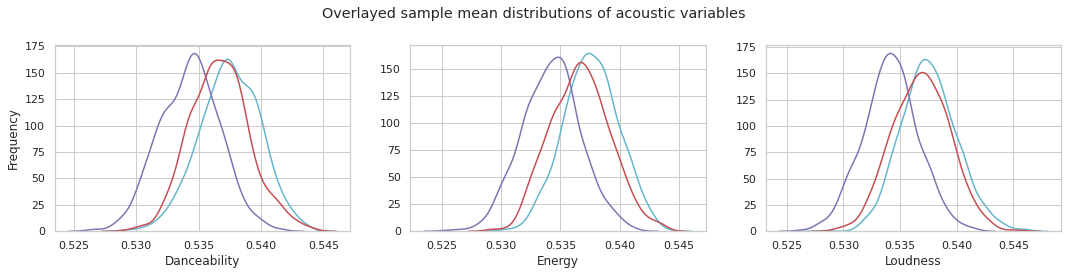

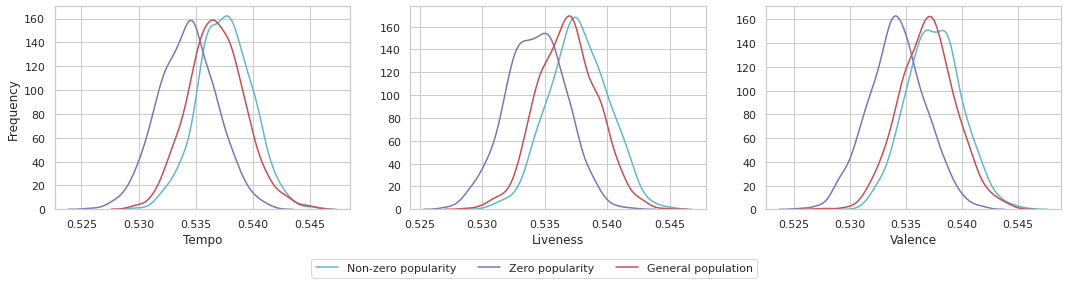

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig_title = fig.suptitle("Overlayed sample mean distributions of acoustic variables")
sns.kdeplot(df_clt_noZeroPopularity["danceability"], ax=ax1, color='c')
sns.kdeplot(df_clt_onlyZeroPopularity["danceability"], ax=ax1, color='m')
sns.kdeplot(df_clt_numVarOnly["danceability"], ax=ax1, color='r')
ax1.set_xlabel("Danceability")
ax1.set_ylabel("Frequency")
sns.kdeplot(df_clt_noZeroPopularity["energy"], ax=ax2, color='c')
sns.kdeplot(df_clt_onlyZeroPopularity["energy"], ax=ax2, color='m')
sns.kdeplot(df_clt_numVarOnly["energy"], ax=ax2, color='r')
ax2.set_xlabel("Energy")
ax2.set_ylabel(" ")
sns.kdeplot(df_clt_noZeroPopularity["loudness"], ax=ax3, color='c')
sns.kdeplot(df_clt_onlyZeroPopularity["loudness"], ax=ax3, color='m')
sns.kdeplot(df_clt_numVarOnly["loudness"], ax=ax3, color='r')
ax3.set_xlabel("Loudness")
ax3.set_ylabel(" ")
fig.tight_layout()

fig_title.set_y(0.95)
fig.subplots_adjust(top=0.82)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
sns.kdeplot(df_clt_noZeroPopularity["tempo"], ax=ax1, color='c')
sns.kdeplot(df_clt_onlyZeroPopularity["tempo"], ax=ax1, color='m')
sns.kdeplot(df_clt_numVarOnly["tempo"], ax=ax1, color='r')
ax1.set_xlabel("Tempo")
ax1.set_ylabel("Frequency")
sns.kdeplot(df_clt_noZeroPopularity["liveness"], ax=ax2, color='c')
sns.kdeplot(df_clt_onlyZeroPopularity["liveness"], ax=ax2, color='m')
sns.kdeplot(df_clt_numVarOnly["liveness"], ax=ax2, color='r')
ax2.set_xlabel("Liveness")
ax2.set_ylabel(" ")
sns.kdeplot(df_clt_noZeroPopularity["valence"], ax=ax3, color='c', label="Non-zero popularity")
sns.kdeplot(df_clt_onlyZeroPopularity["valence"], ax=ax3, color='m', label="Zero popularity")
sns.kdeplot(df_clt_numVarOnly["valence"], ax=ax3, color='r', label="General population")
ax3.set_xlabel("Valence")
ax3.set_ylabel(" ")
fig.tight_layout()

fig.subplots_adjust(bottom=0.25)
fig.legend(loc="lower center", ncol=3)

Overall, sample mean distributions better resemble normal distributions.

---

Means and standard variations are calculated for the hypothesis tests:

In [ ]:
columns_Labels = ['Variable', 'Mean', 'Std. Var.']
rows_Labels = ['danceability', 'energy', 'loudness', 'tempo', 'liveness', 'valence']

In [ ]:
mean_zeroPop = []
for column in rows_Labels:
    mean_zeroPop.append(df_data_onlyZeroPopularity[column].mean())

std_zeroPop = []
for column in rows_Labels:
    std_zeroPop.append(df_data_onlyZeroPopularity[column].std())

zeroPop_stats = np.array([rows_Labels, mean_zeroPop, std_zeroPop]).T

mean_nonzeroPop = []
for column in rows_Labels:
    mean_nonzeroPop.append(df_data_noZeroPopularity[column].mean())

std_nonzeroPop = []
for column in rows_Labels:
    std_nonzeroPop.append(df_data_noZeroPopularity[column].std())

nonzeroPop_stats = np.array([rows_Labels, mean_nonzeroPop, std_nonzeroPop]).T

mean_allPop = []
for column in rows_Labels:
    mean_allPop.append(df_data_numVarOnly[column].mean())

std_allPop = []
for column in rows_Labels:
    std_allPop.append(df_data_numVarOnly[column].std())

allPop_stats = np.array([rows_Labels, mean_allPop, std_allPop]).T

The statistics for the three groups are tabulated:

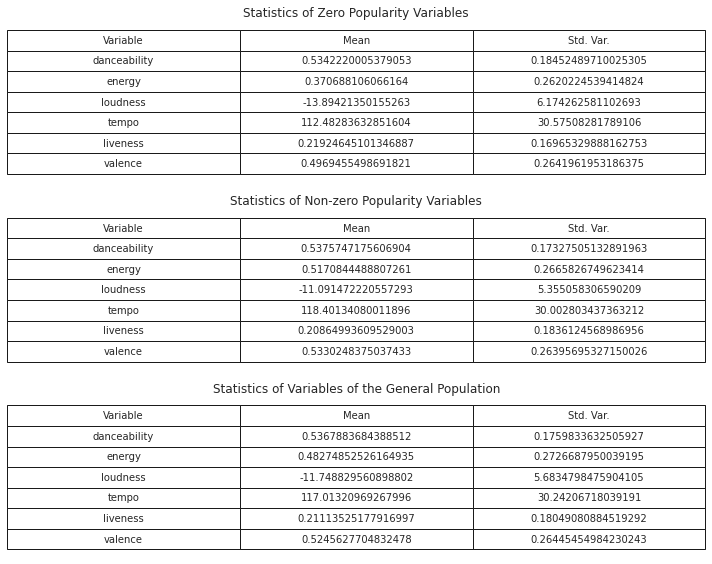

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))
fig.patch.set_visible(False)

fig_title.set_y(0.95)
fig.subplots_adjust(top=1)

ax1.set_title("Statistics of Zero Popularity Variables")
ax1.axis('off')
ax1.axis('tight')
t1 = ax1.table(cellText=zeroPop_stats, colLabels=columns_Labels, loc='center', cellLoc='center')
t1.auto_set_font_size(False)
t1.set_fontsize(10)
t1.scale(1.6,1.6)

ax2.set_title("Statistics of Non-zero Popularity Variables")
ax2.axis('off')
ax2.axis('tight')
t2 = ax2.table(cellText=nonzeroPop_stats, colLabels=columns_Labels, loc='center', cellLoc='center')
t2.auto_set_font_size(False)
t2.set_fontsize(10)
t2.scale(1.6,1.6)

ax3.set_title("Statistics of Variables of the General Population")
ax3.axis('off')
ax3.axis('tight')
t3 = ax3.table(cellText=allPop_stats, colLabels=columns_Labels, loc='center', cellLoc='center')
t3.auto_set_font_size(False)
t3.set_fontsize(10)
t3.scale(1.6,1.6)

fig.subplots_adjust(bottom=0.05)
fig.tight_layout()

The null and alternative hypotheses for each of the variables are:

$H_0: \mu_{pop.>0}=\mu_{pop.=0}$

$H_A: \mu_{pop.>0}\ne\mu_{pop.=0}$

where $pop.$ corresponds to popularity. The p-values to validate the hypotheses are found using the SciPy t-test:

In [ ]:
zeroPop_stats = pd.DataFrame(data=zeroPop_stats, columns=['variable', 'mean', 'std. dev.'])
zeroPop_stats["mean"] = pd.to_numeric(zeroPop_stats["mean"])
zeroPop_stats["std. dev."] = pd.to_numeric(zeroPop_stats["std. dev."])

nonzeroPop_stats = pd.DataFrame(data=nonzeroPop_stats, columns=['variable', 'mean', 'std. dev.'])
nonzeroPop_stats["mean"] = pd.to_numeric(nonzeroPop_stats["mean"])
nonzeroPop_stats["std. dev."] = pd.to_numeric(nonzeroPop_stats["std. dev."])

allPop_stats = pd.DataFrame(data=allPop_stats, columns=['variable', 'mean', 'std. dev.'])
allPop_stats["mean"] = pd.to_numeric(allPop_stats["mean"])
allPop_stats["std. dev."] = pd.to_numeric(allPop_stats["std. dev."])

In [ ]:
p_values = pd.DataFrame(index=np.arange(len(rows_Labels)), columns=['variable', 'p-value'])
p_values["variable"] = rows_Labels

In [ ]:
mean_diff = abs(nonzeroPop_stats["mean"] - zeroPop_stats["mean"])
std_err = (nonzeroPop_stats["std. dev."]**2/sample_size + zeroPop_stats["std. dev."]**2/sample_size)**0.5
t_score = mean_diff/std_err
p_value = 1 - stats.t.cdf(t_score, df=sample_size-1)
p_values["p-value"] = 2*p_value

In [ ]:
p_values["mean difference"] = mean_diff
p_values["null rejected?"] = p_values["p-value"] < 0.05

The final p-values are found below:

In [ ]:
p_values

,variable,p-value,mean difference,null rejected?
0,danceability,3.490230e-01,0.003353,False
1,energy,0.000000e+00,0.146396,True
2,loudness,0.000000e+00,2.802741,True
3,tempo,0.000000e+00,5.918504,True
4,liveness,2.737679e-03,0.010597,True
5,valence,9.425571e-12,0.036079,True


The 95% confidence intervals are also calculated for each variable ($t^{*}=1.96$ for $df=n-1=4999$):


In [ ]:
p_values["confidence interval"] = np.array([mean_diff-1.961*std_err, mean_diff+1.96*std_err]).T.tolist()

In [ ]:
p_values

,variable,p-value,mean difference,null rejected?,confidence interval
0,danceability,3.490230e-01,0.003353,False,"[-0.0036672072798648167, 0.010369061557815237]"
1,energy,0.000000e+00,0.146396,True,"[0.13603001050985586, 0.15675738887128032]"
2,loudness,0.000000e+00,2.802741,True,"[2.5760812900959866, 3.029285688013555]"
3,tempo,0.000000e+00,5.918504,True,"[4.73051911431175, 7.10588402300051]"
4,liveness,2.737679e-03,0.010597,True,"[0.003663567210380452, 0.01752592721154178]"
5,valence,9.425571e-12,0.036079,True,"[0.025722203328125942, 0.046431090408968693]"


From the above confidence interval, danceability is the only variable for which the null hypothesis (mean difference $\mu_{diff}$ is equal to 0) is true and $\mu_{diff}=0$ is in the confidence interval. For the rest of the variables, the alternative hypotheses are true and each $\mu_{diff}$ is in their respective confidence intervals.

From the T-tests and subsequent confidence intervals, it can be concluded that the five variables except for danceability contribute to the popularity of tracks. The significance of each variable to the popularity metric is so far unknown, and the effect of release date is not included, therefore a soft conclusion is more appropriate. 

---

In order to calculate the significance of each variable to the popularity metric, p-values of each accoustic variables are calculated using ordinary least squares regression method. In this method, the aim is to achieve higher R squared values. The ones that have higher p values than the selected significance level are eliminated since they they do not affect the popularity much. It is important to keep in mind that correlated features might have an effect on their p values, therefore these should be treated carefully. Correlation matrix can be found in the data analysis part.

$H_0:$ Column/Feature does not affect song popularity.

$H_A:$ Column/Feature affects song popularity.

If a feature shows p-value larger than 0.05, we do not reject the null hypothesis and conclude that column/feature does not affect the popularity.

In [ ]:
#Feature Elimination Using p-values
# 5% significance level is selected. This means the P-value will be 0.05. 
#identify the feature or predictor which has the highest P-value. 
#If the P-value of this feature is greater than the significance level we selected in the first step, we remove this feature from our dataset.

#Reference website: https://machinelearningmind.com/2019/10/14/feature-elimination-using-p-values/

import statsmodels.api as sm

numeric_variables = ["acousticness", "danceability", "instrumentalness", "liveness","energy","loudness", "speechiness", "tempo", "valence", "popularity","explicit","duration_ms"]
all_variables = df.columns

df_data_numVarOnly = df

for var in all_variables:
   if var not in numeric_variables:
      del df_data_numVarOnly[var]

x = df_data_numVarOnly[df_data_numVarOnly.columns[df_data_numVarOnly.columns != 'popularity']]
y = df_data_numVarOnly.popularity

# Statsmodels.OLS requires us to add a constant.
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
print(results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     6448.
Date:                Sat, 29 May 2021   Prob (F-statistic):               0.00
Time:                        14:17:19   Log-Likelihood:            -7.5572e+05
No. Observations:              174389   AIC:                         1.511e+06
Df Residuals:                  174377   BIC:                         1.512e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               39.6249      0.450  

Regression resulted in `R-squared` equal to 0.289. `p > |t|` values show the significance of each variable. Only the p-values of loudness and tempo are more than 0.05, thus they do not have significant effects on popularity. Loudness and tempo are eliminated and `R-squared` is calculated again. 

In [ ]:
#As we can see ,
#R-squared: 0.240
#Adj. R-squared: 0.240
#p-values can be found under P>|t|

#x.drop('year',axis=1, inplace=True)
#x.drop('duration_ms',axis=1, inplace=True)
#x.drop('explicit',axis=1, inplace=True)
#remove energy
x.drop('loudness',axis=1, inplace=True)
x.drop('tempo',axis=1, inplace=True)


model = sm.OLS(y,x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     7880.
Date:                Sat, 29 May 2021   Prob (F-statistic):               0.00
Time:                        14:17:20   Log-Likelihood:            -7.5572e+05
No. Observations:              174389   AIC:                         1.511e+06
Df Residuals:                  174379   BIC:                         1.512e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               39.4035      0.277  

As expected, `R-squared` (0.289) did not change significantly. All the features left have p-values less than 0.05, meaning that they have a significant effects on popularity. There are no features left to eliminate. This is tested by removing one and checking the change in `R-squared`. 

Let's try removing acousticness:

In [ ]:
#remove acousticness
x.drop('acousticness',axis=1, inplace=True)


model = sm.OLS(y,x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     7644.
Date:                Sat, 29 May 2021   Prob (F-statistic):               0.00
Time:                        14:17:20   Log-Likelihood:            -7.5927e+05
No. Observations:              174389   AIC:                         1.519e+06
Df Residuals:                  174380   BIC:                         1.519e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               22.4115      0.196  

 Indeed, `R squared` value decreased drastically from 0.289 to 0.260.

### **4.2. Statistical Tests for Differences Between Different Eras**

#### **4.2.1. Difference Between Before 70's and After** 

As the difference between the mean scores of the songs that are released before 1970 and after 1970 are high, it's significance is checked . From the figure on the right, it can be observed that the songs that are relased after 1970 obtained better results on average compared to the ones released before 1970. Since p value is very close to 0, null hypothesis which argue that both have equal means is rejected. 

To remove this bias, further analysis is done with the songs that are released after 1970 by dividing them into 4 groups: 60's, 70's, 80', 90's and 2000's. And the genres will be categorized accordingly to analyze each genre separeatly from each other.

In [ ]:
import pandas as pd
import numpy as np
import re

folder = "CS 210 - Project/"
df = pd.read_csv(join(path_prefix, folder,"data.csv"))

#df["popularity"] != 0
df = df[df["popularity"]  !=0]
test_type = "popularity"

old = df[df["year"]  <= 1970][test_type]  # mode == 1 



new = df[df["year"]  >= 1970][test_type] 

mean score of songs which is released before 1970: 19.63
mean score of songs which is released after 1970 1: 40.22


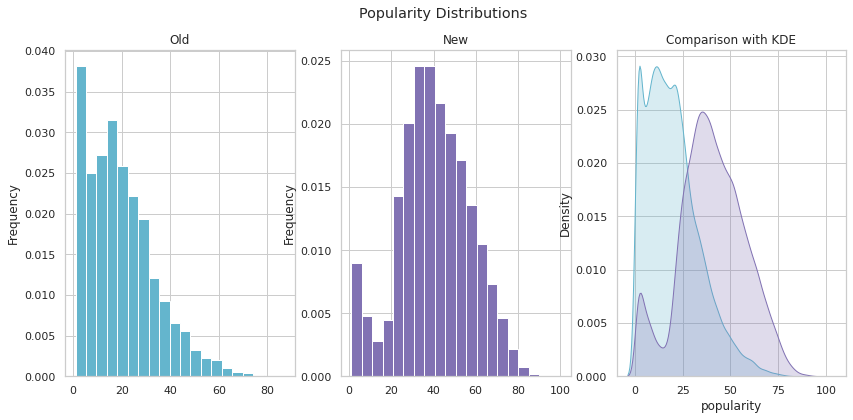

In [ ]:

print(f"mean score of songs which is released before 1970: {old.mean():.2f}")
print(f"mean score of songs which is released after 1970 1: {new.mean():.2f}")
#T-Test

#It is used to determine if there is a significant difference between the means of two groups.
fig, ax = plt.subplots(1, 3, figsize=(14,6))  # a figure with 1 row and 3 columns
                                              # ax variable stores a list with 3 elements
                                              # each element in ax correspons to chart
        
old.plot(kind="hist", ax=ax[0], bins=20, label="old", color="c", density=True)
ax[0].set_title("Old")

new.plot(kind="hist", ax=ax[1], bins=20, label="new", color="m", density=True)
ax[1].set_title("New")

sns.kdeplot(old, shade=True, label="Old Songs (released before 1970)", ax=ax[2], color="c")
sns.kdeplot(new, shade=True, label="New Songs (released after 1970)", ax=ax[2], color="m")
ax[2].set_title("Comparison with KDE")

plt.suptitle("Popularity Distributions")
plt.show()

In [ ]:
#From the figure above, we can see that the songs that are relased after 1970 obtained better results on average compared to the ones released before 1970.
#Now, let's show this difference statistically by applying a significance test.
stats.ttest_ind(old, new, equal_var=False)  

#Since the obtained p-value (0) is less than or equal to the significance value, the null hypothesis is rejected, otherwise we fail to reject the null hypothesis.

Ttest_indResult(statistic=-234.315262223173, pvalue=0.0)

#### **4.2.2. Difference Within Most Popular Genres According to Era**


Since it has been observed that from the means, the most popular genres (after removed the 0 popularity songs) were **Rap**, **Hip-Hop** and **Pop** in Section 2.2,  analysis will be based on those genres.

In [ ]:
# Start by initializing the data set again.

df_w_eras = merged
df_w_eras.head()

,acousticness_x,artists,danceability_x,duration_ms_x,energy_x,explicit,id,instrumentalness_x,key_x,liveness_x,loudness_x,mode_x,name,popularity_x,release_date,speechiness_x,tempo_x,valence_x,year,acousticness_y,danceability_y,duration_ms_y,energy_y,instrumentalness_y,liveness_y,loudness_y,speechiness_y,tempo_y,valence_y,popularity_y,key_y,mode_y,count,genres,Classified Genres
0,0.991,Mamie Smith,0.598,168333,0.2240,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.379,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.634,1920,0.983,0.62725,177981.75,0.184556,0.000288,0.372625,-12.800313,0.121438,113.009938,0.641062,3.1875,0,1,16,"['harlem renaissance', 'traditional blues']",R&B
1,0.993,Mamie Smith,0.647,163827,0.1860,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.519,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.689,1920,0.983,0.62725,177981.75,0.184556,0.000288,0.372625,-12.800313,0.121438,113.009938,0.641062,3.1875,0,1,16,"['harlem renaissance', 'traditional blues']",R&B
2,0.992,Mamie Smith,0.782,195200,0.0573,0,5DlCyqLyX2AOVDTjjkDZ8x,0.000002,5,0.176,-12.453,1,Don't You Advertise Your Man,5,1920,0.0592,85.652,0.487,1920,0.983,0.62725,177981.75,0.184556,0.000288,0.372625,-12.800313,0.121438,113.009938,0.641062,3.1875,0,1,16,"['harlem renaissance', 'traditional blues']",R&B
3,0.995,Mamie Smith,0.482,198000,0.2290,0,0lqEx4vktZP1y9hnwfF27Y,0.000061,7,0.549,-12.619,1,Kansas City Man Blues - 78rpm Version,4,1920,0.0812,77.232,0.461,1920,0.983,0.62725,177981.75,0.184556,0.000288,0.372625,-12.800313,0.121438,113.009938,0.641062,3.1875,0,1,16,"['harlem renaissance', 'traditional blues']",R&B
4,0.992,Mamie Smith,0.574,189800,0.1380,0,4HYmmG8uHL2hP4zSFWavKF,0.000492,3,0.233,-14.171,1,Miss Jenny's Ball (aka There'll Be No Freebies...,1,1920,0.1090,158.422,0.764,1920,0.983,0.62725,177981.75,0.184556,0.000288,0.372625,-12.800313,0.121438,113.009938,0.641062,3.1875,0,1,16,"['harlem renaissance', 'traditional blues']",R&B


For this purpose, it has been created another function to classify all th songs to their era's based on the year they have been released.

In [ ]:
def genre_classifier_era(year):

  #print(genre)
  # Genre name can be added to the era

  if (2010 <= year):
    return "After 2010"

  elif (2000 <= year <= 2010):
    return "2000's"
  
  elif (1990 <= year <= 2000):
    return "90's"

  elif (1980 <= year <= 1990):
    return "80's"

  elif (1970 <= year <= 1980):
    return "70's"

  elif (1960 <= year <= 1970):
    return "60's"

  else:
    return "Before 60's"

df_w_eras["Classified Era of Genres"] = df_w_eras['year'].apply(genre_classifier_era)  # Resulting series will be stored in a new column

# Take a look at the data table
df_w_eras.head()

,acousticness_x,artists,danceability_x,duration_ms_x,energy_x,explicit,id,instrumentalness_x,key_x,liveness_x,loudness_x,mode_x,name,popularity_x,release_date,speechiness_x,tempo_x,valence_x,year,acousticness_y,danceability_y,duration_ms_y,energy_y,instrumentalness_y,liveness_y,loudness_y,speechiness_y,tempo_y,valence_y,popularity_y,key_y,mode_y,count,genres,Classified Genres,Classified Era of Genres
0,0.991,Mamie Smith,0.598,168333,0.2240,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.379,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.634,1920,0.983,0.62725,177981.75,0.184556,0.000288,0.372625,-12.800313,0.121438,113.009938,0.641062,3.1875,0,1,16,"['harlem renaissance', 'traditional blues']",R&B,Before 60's
1,0.993,Mamie Smith,0.647,163827,0.1860,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.519,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.689,1920,0.983,0.62725,177981.75,0.184556,0.000288,0.372625,-12.800313,0.121438,113.009938,0.641062,3.1875,0,1,16,"['harlem renaissance', 'traditional blues']",R&B,Before 60's
2,0.992,Mamie Smith,0.782,195200,0.0573,0,5DlCyqLyX2AOVDTjjkDZ8x,0.000002,5,0.176,-12.453,1,Don't You Advertise Your Man,5,1920,0.0592,85.652,0.487,1920,0.983,0.62725,177981.75,0.184556,0.000288,0.372625,-12.800313,0.121438,113.009938,0.641062,3.1875,0,1,16,"['harlem renaissance', 'traditional blues']",R&B,Before 60's
3,0.995,Mamie Smith,0.482,198000,0.2290,0,0lqEx4vktZP1y9hnwfF27Y,0.000061,7,0.549,-12.619,1,Kansas City Man Blues - 78rpm Version,4,1920,0.0812,77.232,0.461,1920,0.983,0.62725,177981.75,0.184556,0.000288,0.372625,-12.800313,0.121438,113.009938,0.641062,3.1875,0,1,16,"['harlem renaissance', 'traditional blues']",R&B,Before 60's
4,0.992,Mamie Smith,0.574,189800,0.1380,0,4HYmmG8uHL2hP4zSFWavKF,0.000492,3,0.233,-14.171,1,Miss Jenny's Ball (aka There'll Be No Freebies...,1,1920,0.1090,158.422,0.764,1920,0.983,0.62725,177981.75,0.184556,0.000288,0.372625,-12.800313,0.121438,113.009938,0.641062,3.1875,0,1,16,"['harlem renaissance', 'traditional blues']",R&B,Before 60's


In [ ]:
# Take a look at the data table
df_w_eras.tail()

,acousticness_x,artists,danceability_x,duration_ms_x,energy_x,explicit,id,instrumentalness_x,key_x,liveness_x,loudness_x,mode_x,name,popularity_x,release_date,speechiness_x,tempo_x,valence_x,year,acousticness_y,danceability_y,duration_ms_y,energy_y,instrumentalness_y,liveness_y,loudness_y,speechiness_y,tempo_y,valence_y,popularity_y,key_y,mode_y,count,genres,Classified Genres,Classified Era of Genres
218698,0.966,Johannes Bornlöf,0.269,424200,0.0926,0,1Svqb7CX6rQvJpZY3iVBXh,0.890,9,0.0992,-24.280,0,Divenire,0,2021-01-23,0.0609,120.323,0.1020,2021,0.978857,0.303,358997.571429,0.071614,0.889143,0.104214,-26.142143,0.055614,120.350429,0.095443,0.0,9,0,14,"['background music', 'calming instrumental', '...",Classical,After 2010
218699,0.995,Johannes Bornlöf,0.297,349200,0.0287,0,2LeqqwzobL5ktfQhWA3bHh,0.908,8,0.0995,-30.008,1,Nuvole bianche,0,2021-01-23,0.0564,141.636,0.0678,2021,0.978857,0.303,358997.571429,0.071614,0.889143,0.104214,-26.142143,0.055614,120.350429,0.095443,0.0,9,0,14,"['background music', 'calming instrumental', '...",Classical,After 2010
218700,0.995,Johannes Bornlöf,0.343,206700,0.0165,0,3Glmyv3hbGGTgeR3FZrxJA,0.878,9,0.0774,-30.915,0,Una Mattina,0,2021-01-23,0.0455,126.970,0.1510,2021,0.978857,0.303,358997.571429,0.071614,0.889143,0.104214,-26.142143,0.055614,120.350429,0.095443,0.0,9,0,14,"['background music', 'calming instrumental', '...",Classical,After 2010
218701,0.966,Johannes Bornlöf,0.269,424200,0.0926,0,4yBReaKJW78ZYCHpc1cfaK,0.890,9,0.0992,-24.280,0,Divenire,0,2021-01-23,0.0609,120.323,0.1020,2021,0.978857,0.303,358997.571429,0.071614,0.889143,0.104214,-26.142143,0.055614,120.350429,0.095443,0.0,9,0,14,"['background music', 'calming instrumental', '...",Classical,After 2010
218702,0.988,Johannes Bornlöf,0.316,303333,0.0573,0,6QGVWUbmlePAiY5zJjfCmT,0.879,3,0.1200,-24.121,1,Night,0,2021-01-23,0.0515,81.070,0.0373,2021,0.978857,0.303,358997.571429,0.071614,0.889143,0.104214,-26.142143,0.055614,120.350429,0.095443,0.0,9,0,14,"['background music', 'calming instrumental', '...",Classical,After 2010


##### **RAP**
In here, it has been investigated that whether Rap genre was affected by the era it belongs, i.e. whether there was a significant difference betweeen different years for popularity.

- $\large H_0:$ There is no significant effect of era on popularity on Rap songs.
- $\large H_A:$ Rap songs' popularity is affected by the era.

In [ ]:
df_w_eras[df_w_eras["Classified Genres"] == "Rap"].head()

,acousticness_x,artists,danceability_x,duration_ms_x,energy_x,explicit,id,instrumentalness_x,key_x,liveness_x,loudness_x,mode_x,name,popularity_x,release_date,speechiness_x,tempo_x,valence_x,year,acousticness_y,danceability_y,duration_ms_y,energy_y,instrumentalness_y,liveness_y,loudness_y,speechiness_y,tempo_y,valence_y,popularity_y,key_y,mode_y,count,genres,Classified Genres,Classified Era of Genres
6818,0.3670,Rafa,0.577,150082,0.480,0,4vESzvEqHblxeJ8fUOwqHj,0.000000,8,0.0857,-13.550,0,Não Vou Desistir,0,1921-01-16,0.2110,121.673,0.344,1921,0.367000,0.5770,150082.0,0.480000,0.000000,0.08570,-13.550000,0.2110,121.6730,0.344000,0.000000,8,0,1,"['reggaeton', 'reggaeton flow', 'trap latino']",Rap,Before 60's
87985,0.0206,Omega,0.342,349413,0.429,0,3nDfx9WqSNOfbuCP4yonzj,0.709000,5,0.1490,-8.439,0,Gyöngyhajú lány,53,1969,0.0356,68.387,0.392,1969,0.042550,0.5975,297240.0,0.559000,0.354501,0.09525,-6.901500,0.0460,96.6985,0.670000,55.500000,10,0,4,['rap dominicano'],Rap,60's
87986,0.0645,Omega,0.853,245067,0.689,0,0OyHCmkCp2qZJ44ZKB26fX,0.000003,10,0.0415,-5.364,0,Si Te Vas/Que Tengo Que Hacer - Original Remix,58,2009-07-28,0.0564,125.010,0.948,2009,0.042550,0.5975,297240.0,0.559000,0.354501,0.09525,-6.901500,0.0460,96.6985,0.670000,55.500000,10,0,4,['rap dominicano'],Rap,2000's
93259,0.4120,Malo,0.562,395200,0.561,0,5QoFWpXoaUyT44VmR98wLl,0.000020,11,0.0917,-10.954,0,Suavecito,50,1972-01,0.0343,113.911,0.666,1972,0.356983,0.5070,417386.5,0.733167,0.007477,0.12750,-10.675667,0.0441,130.5510,0.606567,34.333333,11,1,12,"['dfw rap', 'melodic rap', 'rap']",Rap,70's
93260,0.4840,Malo,0.615,389533,0.895,0,5HkvsZyaMPwhq38v0o8kAf,0.033600,7,0.0964,-8.933,1,Nena,33,1972-01,0.0408,148.748,0.866,1972,0.356983,0.5070,417386.5,0.733167,0.007477,0.12750,-10.675667,0.0441,130.5510,0.606567,34.333333,11,1,12,"['dfw rap', 'melodic rap', 'rap']",Rap,70's


In [ ]:
# Drop the 0 popularity songs.
df_w_eras = df_w_eras[df_w_eras["popularity_y"]  !=0]

df_era = ["popularity_y"]
test_type_era = "popularity_y"

# Divide the data set for eras that will be investigated

rap = df_w_eras[df_w_eras["Classified Genres"] == "Rap"]

rap_70 = rap[rap["Classified Era of Genres"] == "70's"][test_type_era]

rap_80 = rap[rap["Classified Era of Genres"] == "80's"][test_type_era]

rap_90 = rap[rap["Classified Era of Genres"] == "90's"][test_type_era]

rap_2000 = rap[rap["Classified Era of Genres"] == "2000's"][test_type_era]

Mean score of popularity of Rap Songs of 70's: 31.17
Mean score of popularity of Rap Songs of 80's: 42.08
Mean score of popularity of Rap Songs of 90's: 41.29
Mean score of popularity of Rap Songs of 2000's: 50.09


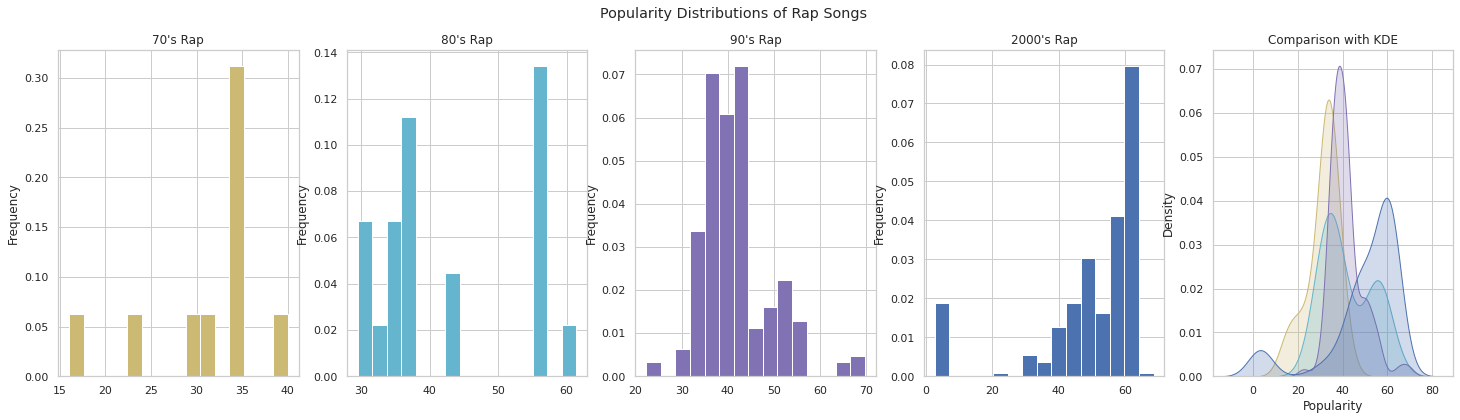

In [ ]:
print(f"Mean score of popularity of Rap Songs of 70's: {rap_70.mean():.2f}")
print(f"Mean score of popularity of Rap Songs of 80's: {rap_80.mean():.2f}")
print(f"Mean score of popularity of Rap Songs of 90's: {rap_90.mean():.2f}")
print(f"Mean score of popularity of Rap Songs of 2000's: {rap_2000.mean():.2f}")

#It is used to determine if there is a significant difference between the means of two groups.
fig, ax = plt.subplots(1, 5, figsize=(25,6))  # a figure with 1 row and 4 columns
                                              # ax variable stores a list with 4 elements
     
                                              # each element in ax correspons to chart
rap_70.plot(kind="hist", ax=ax[0], bins=15, label="70's Rap", color="y", density=True)
ax[0].set_title("70's Rap")

rap_80.plot(kind="hist", ax=ax[1], bins=15, label="80's Rap", color="c", density=True)
ax[1].set_title("80's Rap")

rap_90.plot(kind="hist", ax=ax[2], bins=15, label="90's Rap", color="m", density=True)
ax[2].set_title("90's Rap")

rap_2000.plot(kind="hist", ax=ax[3], bins=15, label="2000's Rap", color="b", density=True)
ax[3].set_title("2000's Rap")

sns.kdeplot(rap_70, shade=True, label="Rap Songs of 70's", ax=ax[4], color="y")
sns.kdeplot(rap_80, shade=True, label="Rap Songs of 80's", ax=ax[4], color="c")
sns.kdeplot(rap_90, shade=True, label="Rap Songs of 90's", ax=ax[4], color="m")
sns.kdeplot(rap_2000, shade=True, label="Rap Songs of 2000's", ax=ax[4], color="b")
ax[4].set_title("Comparison with KDE")
ax[4].set_xlabel("Popularity")

plt.suptitle("Popularity Distributions of Rap Songs")
plt.show()

As it can be seen above and especially from KDE plot, 70's Rap was closest to normal distribution then 90's. But 80's nearly shows a denstiy distribution close to bimodal distribution and 2000's rap is highly negatively skewed. However, since the sample size is big enough (N > 20), the distrbutions will be used for further analysis.

Here, one-way between samples ANOVA will be conducted to conclude whether there is a significant difference between different eras of Rap. To do so, first Levene's test will be conducted for the assumption check.

In [ ]:
stats.levene(rap_70, rap_80, rap_90, rap_2000)

LeveneResult(statistic=9.975250480298461, pvalue=2.175357098019502e-06)

As it can be seen from above, the Levene's test for homogenity of variances is violated, *p* < .001, which was expected when looked at the graph of their distribtions. Thus, the approach should be more suspicious when dicussing the result of ANOVA, for the simplicity, there has been no correction applied for the test.

In [ ]:
# Conduct ANOVA
stats.f_oneway(rap_70, rap_80, rap_90, rap_2000)

F_onewayResult(statistic=22.16870744600251, pvalue=1.8506499141071616e-13)

As it can be seen above, even though one should be careful with interpreting the results because ıf the failure in the assumpiton check, the result seems to be highly significant, *p* < .001. That means, we can reject the null hypothesis and conclude that there is a difference betweeen different eras of on popularity, spesifically for 70's, 80's, 90's, and 2000's for RAP.

#####**HIP-HOP**



In here, it has been investigated that whether Hip-Hop genre was affected by the era it belongs, i.e. whether there was a significant difference betweeen different years for popularity.

- $\large H_0:$ There is no significant effect of era on popularity on Hip-Hop songs.
- $\large H_A:$ Hip-Hop songs' popularity is affected by the era.

In [ ]:
df_w_eras[df_w_eras["Classified Genres"] == "Hip-Hop"].head()

,acousticness_x,artists,danceability_x,duration_ms_x,energy_x,explicit,id,instrumentalness_x,key_x,liveness_x,loudness_x,mode_x,name,popularity_x,release_date,speechiness_x,tempo_x,valence_x,year,acousticness_y,danceability_y,duration_ms_y,energy_y,instrumentalness_y,liveness_y,loudness_y,speechiness_y,tempo_y,valence_y,popularity_y,key_y,mode_y,count,genres,Classified Genres,Classified Era of Genres
21277,0.970,Unknown Orchestra,0.160,270088,0.340,0,04fpXfm8WfsSk7Mh0VYeLj,0.288000,1,0.114,-12.709,1,"Der Rosenkavalier, Op. 59, TrV 227: Hab mir's ...",1,1929-01-01,0.0408,83.029,0.0739,1929,0.986871,0.298613,225405.935484,0.226581,0.168521,0.270535,-13.348774,0.067635,81.955613,0.197419,0.225806,3,1,31,"['chillwave', 'indie rock', 'indie soul', 'kiw...",Hip-Hop,Before 60's
21278,0.976,Unknown Orchestra,0.381,265283,0.179,0,0i6OhFjTxLS0n42NAOBHIq,0.000483,3,0.082,-14.569,1,"La traviata: Ach, ihres Auges Zauberblick (Alf...",0,1929-01-01,0.0535,77.399,0.2910,1929,0.986871,0.298613,225405.935484,0.226581,0.168521,0.270535,-13.348774,0.067635,81.955613,0.197419,0.225806,3,1,31,"['chillwave', 'indie rock', 'indie soul', 'kiw...",Hip-Hop,Before 60's
21279,0.990,Unknown Orchestra,0.251,474084,0.114,0,0lFrdmtbQK95vmjGISQqE3,0.009570,4,0.126,-14.516,1,"Fidelio, Op. 72: Abscheulicher! Wo eilst du hin?",0,1929-01-01,0.0493,74.021,0.0733,1929,0.986871,0.298613,225405.935484,0.226581,0.168521,0.270535,-13.348774,0.067635,81.955613,0.197419,0.225806,3,1,31,"['chillwave', 'indie rock', 'indie soul', 'kiw...",Hip-Hop,Before 60's
21280,0.987,Unknown Orchestra,0.529,195224,0.207,0,0s5p1UJrQPGIVxoY00hjEf,0.002140,0,0.801,-12.421,0,Addio mia bella Napoli,0,1929-01-01,0.1350,76.573,0.2760,1929,0.986871,0.298613,225405.935484,0.226581,0.168521,0.270535,-13.348774,0.067635,81.955613,0.197419,0.225806,3,1,31,"['chillwave', 'indie rock', 'indie soul', 'kiw...",Hip-Hop,Before 60's
21281,0.990,Unknown Orchestra,0.355,168086,0.244,0,5KB2FrxDbxLd2rg7T9LeRI,0.511000,11,0.502,-16.149,1,Otello: Era la notte,0,1925-01-01,0.0943,72.424,0.1040,1925,0.986871,0.298613,225405.935484,0.226581,0.168521,0.270535,-13.348774,0.067635,81.955613,0.197419,0.225806,3,1,31,"['chillwave', 'indie rock', 'indie soul', 'kiw...",Hip-Hop,Before 60's


In [ ]:
# Drop the 0 popularity songs.
df_w_eras = df_w_eras[df_w_eras["popularity_y"]  !=0]

df_era = ["popularity_y"]
test_type_era = "popularity_y"

# Divide the data set for eras that will be investigated

hiphop = df_w_eras[df_w_eras["Classified Genres"] == "Hip-Hop"]

hiphop_70 = hiphop[hiphop["Classified Era of Genres"] == "70's"][test_type_era]

hiphop_80 = hiphop[hiphop["Classified Era of Genres"] == "80's"][test_type_era]

hiphop_90 = hiphop[hiphop["Classified Era of Genres"] == "90's"][test_type_era]

hiphop_2000 = hiphop[hiphop["Classified Era of Genres"] == "2000's"][test_type_era]

Mean score of popularity of Hip-Hop Songs of 70's: 34.97
Mean score of popularity of Hip-Hop Songs of 80's: 35.97
Mean score of popularity of Hip-Hop Songs of 90's: 45.30
Mean score of popularity of Hip-Hop Songs of 2000's: 50.29


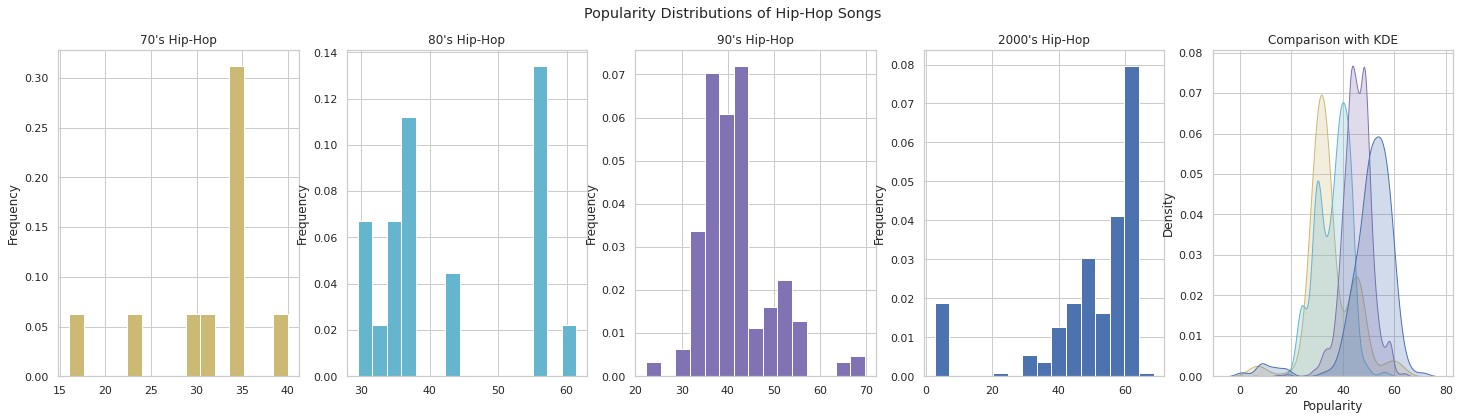

In [ ]:
print(f"Mean score of popularity of Hip-Hop Songs of 70's: {hiphop_70.mean():.2f}")
print(f"Mean score of popularity of Hip-Hop Songs of 80's: {hiphop_80.mean():.2f}")
print(f"Mean score of popularity of Hip-Hop Songs of 90's: {hiphop_90.mean():.2f}")
print(f"Mean score of popularity of Hip-Hop Songs of 2000's: {hiphop_2000.mean():.2f}")

#It is used to determine if there is a significant difference between the means of two groups.
fig, ax = plt.subplots(1, 5, figsize=(25,6))  # a figure with 1 row and 4 columns
                                              # ax variable stores a list with 4 elements
     
                                              # each element in ax correspons to chart
rap_70.plot(kind="hist", ax=ax[0], bins=15, label="80's Hip-Hop", color="y", density=True)
ax[0].set_title("70's Hip-Hop")

rap_80.plot(kind="hist", ax=ax[1], bins=15, label="80's Hip-Hop", color="c", density=True)
ax[1].set_title("80's Hip-Hop")

rap_90.plot(kind="hist", ax=ax[2], bins=15, label="90's Hip-Hop", color="m", density=True)
ax[2].set_title("90's Hip-Hop")

rap_2000.plot(kind="hist", ax=ax[3], bins=15, label="2000's Hip-Hop", color="b", density=True)
ax[3].set_title("2000's Hip-Hop")

sns.kdeplot(hiphop_70, shade=True, label="Hip-Hop Songs of 70's", ax=ax[4], color="y")
sns.kdeplot(hiphop_80, shade=True, label="Hip-Hop Songs of 80's", ax=ax[4], color="c")
sns.kdeplot(hiphop_90, shade=True, label="Hip-Hop Songs of 90's", ax=ax[4], color="m")
sns.kdeplot(hiphop_2000, shade=True, label="Hip-Hop Songs of 2000's", ax=ax[4], color="b")
ax[4].set_title("Comparison with KDE")
ax[4].set_xlabel("Popularity")

plt.suptitle("Popularity Distributions of Hip-Hop Songs")
plt.show()

As it can be seen above and especially from KDE plot, 2000's Hip-Hop was closest to normal distribution with slight negative skew. But others nearly shows a denstiy distribution close to bimodal distribution and 2000's rap is highly negatively skewed. However, since the sample size is big enough (N > 20), the distrbutions will be used for further analysis.

Here, one-way between samples ANOVA will be conducted to conclude whether there is a significant difference between different eras of Hip-Hop. To do so, first Levene's test will be conducted for the assumption check.

In [ ]:
stats.levene(hiphop_70, hiphop_80, hiphop_90, hiphop_2000)

LeveneResult(statistic=52.239425577859755, pvalue=2.7421268861639036e-33)

As it can be seen from above, the Levene's test for homogenity of variances is violated, *p* < .001 and with a so small *p*, which was expected when looked at the graph of their distribtions. Thus, the approach should be more suspicious when dicussing the result of ANOVA, for the simplicity, there has been no correction applied for the test.

In [ ]:
# Conduct ANOVA
stats.f_oneway(hiphop_70, hiphop_80, hiphop_90, hiphop_2000)

F_onewayResult(statistic=487.2498008435422, pvalue=5.698917138239918e-281)

However, since the p-value was so small, and therefore suggested a significance difference among different eras for Hip-Hop, it is suspicious to have that much different results than RAP. That's why it has been also applied Central Limit Theorem for the distributions for Hip-Hop popularity for different eras.

Results can be seen from below code cells. But in case of restarting the notebook, the code cells will give an error, because since CLT theorem did not add anything to the significance of results in the method, the related code has been removed. Thus, the codes are in comments but the results are addded as text boxes.

In [ ]:
# stats.levene(hiphop_70_CLT["Popularity"], hiphop_80_CLT["Popularity"], hiphop_90_CLT["Popularity"], hiphop_2000_CLT["Popularity"])

LeveneResult(statistic=16.760119309695643, pvalue=2.86526628208935e-10)

In [ ]:
# Conduct ANOVA
# stats.f_oneway(hiphop_70_CLT["Popularity"], hiphop_80_CLT["Popularity"], hiphop_90_CLT["Popularity"], hiphop_2000_CLT["Popularity"])

F_onewayResult(statistic=36235.211809362656, pvalue=0.0)


As can be seen above, even though after CLT applied, the p value for the assumotion check increased, it still violates. And for the ANOVA, the p value was so small that printed as 0.0. Thus, we did nıt use those probabilities.

As a result, even though one should be careful with interpreting the results because of the failure in the assumpiton check, the result seems to be highly significant, *p* < .001. That means, we can reject the null hypothesis and conclude that there is a difference betweeen different eras of on popularity, spesifically for 70's, 80's, 90's, and 2000's for Hip-Hop.

##### **POP**

In here, it has been investigated that whether Pop genre was affected by the era it belongs, i.e. whether there was a significant difference betweeen different years for popularity.

- $\large H_0:$ There is no significant effect of era on popularity on Pop songs.
- $\large H_A:$ Pop songs' popularity is affected by the era.

In [ ]:
df_w_eras[df_w_eras["Classified Genres"] == "Pop"].head()

,acousticness_x,artists,danceability_x,duration_ms_x,energy_x,explicit,id,instrumentalness_x,key_x,liveness_x,loudness_x,mode_x,name,popularity_x,release_date,speechiness_x,tempo_x,valence_x,year,acousticness_y,danceability_y,duration_ms_y,energy_y,instrumentalness_y,liveness_y,loudness_y,speechiness_y,tempo_y,valence_y,popularity_y,key_y,mode_y,count,genres,Classified Genres,Classified Era of Genres
2343,0.381,ST,0.936,166113,0.372,1,0XGoQAeP51ySJbtqXhuJrl,0.000000,0,0.0830,-11.634,1,Comme à l'époque,0,1920,0.4550,133.047,0.222,1920,0.516083,0.7375,200574.75,0.39825,0.000006,0.129308,-10.837833,0.23735,133.48,0.281583,0.083333,0,0,12,"['houston rap', 'pop', 'pop rap', 'trap queen']",Pop,Before 60's
2344,0.689,ST,0.690,144588,0.324,1,12EoJ4NTFAwRDsV0TeiSqD,0.000000,9,0.2820,-13.748,1,YP,0,1920,0.0726,130.024,0.265,1920,0.516083,0.7375,200574.75,0.39825,0.000006,0.129308,-10.837833,0.23735,133.48,0.281583,0.083333,0,0,12,"['houston rap', 'pop', 'pop rap', 'trap queen']",Pop,Before 60's
2345,0.117,ST,0.842,227500,0.382,1,2gUkW0vlRnpcX57aESZWHQ,0.000000,3,0.0882,-10.918,0,Radar,0,1920,0.5090,137.980,0.493,1920,0.516083,0.7375,200574.75,0.39825,0.000006,0.129308,-10.837833,0.23735,133.48,0.281583,0.083333,0,0,12,"['houston rap', 'pop', 'pop rap', 'trap queen']",Pop,Before 60's
2346,0.434,ST,0.685,244219,0.458,1,2gzzgyvxUNjF1Q6B2zjjef,0.000001,9,0.3040,-8.903,1,Four,0,1920,0.2600,149.987,0.456,1920,0.516083,0.7375,200574.75,0.39825,0.000006,0.129308,-10.837833,0.23735,133.48,0.281583,0.083333,0,0,12,"['houston rap', 'pop', 'pop rap', 'trap queen']",Pop,Before 60's
2347,0.685,ST,0.799,160105,0.299,1,3YKOfuDR93zR78bfaFX6ad,0.000015,10,0.1180,-12.239,1,Honey,0,1920,0.0704,98.960,0.176,1920,0.516083,0.7375,200574.75,0.39825,0.000006,0.129308,-10.837833,0.23735,133.48,0.281583,0.083333,0,0,12,"['houston rap', 'pop', 'pop rap', 'trap queen']",Pop,Before 60's


In [ ]:
# Drop the 0 popularity songs.
df_w_eras = df_w_eras[df_w_eras["popularity_y"]  !=0]

df_era = ["popularity_y"]
test_type_era = "popularity_y"

# Divide the data set for eras that will be investigated

pop = df_w_eras[df_w_eras["Classified Genres"] == "Pop"]

pop_70 = pop[pop["Classified Era of Genres"] == "70's"][test_type_era]

pop_80 = pop[pop["Classified Era of Genres"] == "80's"][test_type_era]

pop_90 = pop[pop["Classified Era of Genres"] == "90's"][test_type_era]

pop_2000 = pop[pop["Classified Era of Genres"] == "2000's"][test_type_era]

Mean score of popularity of Pop Songs of 70's: 37.69
Mean score of popularity of Pop Songs of 80's: 40.69
Mean score of popularity of Pop Songs of 90's: 45.90
Mean score of popularity of Pop Songs of 2000's: 51.20


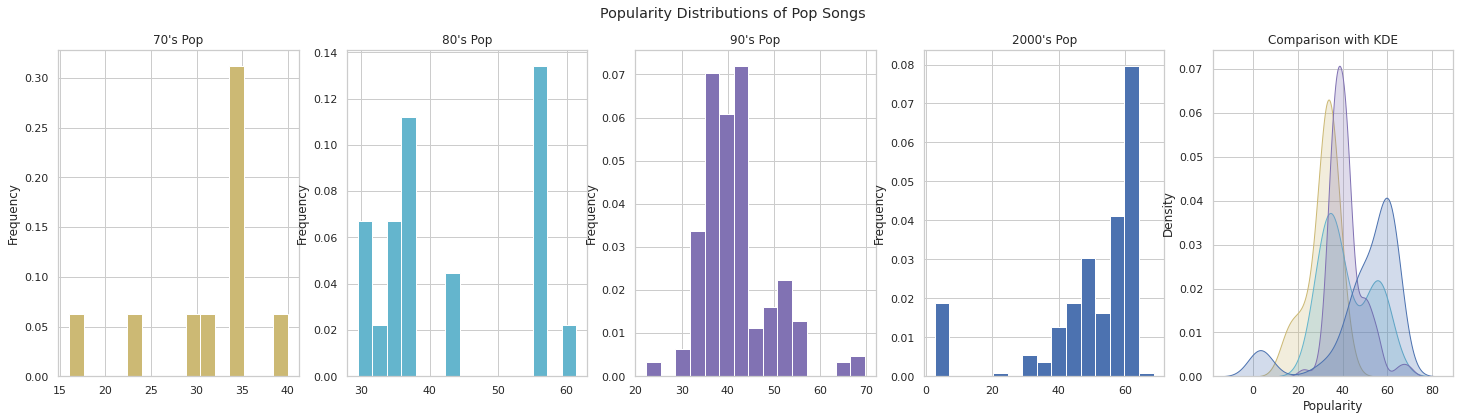

In [ ]:
print(f"Mean score of popularity of Pop Songs of 70's: {pop_70.mean():.2f}")
print(f"Mean score of popularity of Pop Songs of 80's: {pop_80.mean():.2f}")
print(f"Mean score of popularity of Pop Songs of 90's: {pop_90.mean():.2f}")
print(f"Mean score of popularity of Pop Songs of 2000's: {pop_2000.mean():.2f}")

#It is used to determine if there is a significant difference between the means of two groups.
fig, ax = plt.subplots(1, 5, figsize=(25,6))  # a figure with 1 row and 4 columns
                                              # ax variable stores a list with 4 elements
     
                                              # each element in ax correspons to chart
rap_70.plot(kind="hist", ax=ax[0], bins=15, label="70's Pop", color="y", density=True)
ax[0].set_title("70's Pop")

rap_80.plot(kind="hist", ax=ax[1], bins=15, label="80's Pop", color="c", density=True)
ax[1].set_title("80's Pop")

rap_90.plot(kind="hist", ax=ax[2], bins=15, label="90's Pop", color="m", density=True)
ax[2].set_title("90's Pop")

rap_2000.plot(kind="hist", ax=ax[3], bins=15, label="2000's Pop", color="b", density=True)
ax[3].set_title("2000's Pop")

sns.kdeplot(rap_70, shade=True, label="Pop Songs of 70's", ax=ax[4], color="y")
sns.kdeplot(rap_80, shade=True, label="Pop Songs of 80's", ax=ax[4], color="c")
sns.kdeplot(rap_90, shade=True, label="Pop Songs of 90's", ax=ax[4], color="m")
sns.kdeplot(rap_2000, shade=True, label="Pop Songs of 2000's", ax=ax[4], color="b")
ax[4].set_title("Comparison with KDE")
ax[4].set_xlabel("Popularity")

plt.suptitle("Popularity Distributions of Pop Songs")
plt.show()

As it can be seen above and especially from KDE plot, 70's Pop was closest to normal distribution then 90's. But 80's nearly shows a denstiy distribution close to bimodal distribution and 2000's rap is highly negatively skewed. These results are similar to the ones of RAP than Hip-Hop. However, again since the sample size is big enough (N > 20), the distrbutions will be used for further analysis.

Here, one-way between samples ANOVA will be conducted to conclude whether there is a significant difference between different eras of Pop. To do so, first Levene's test will be conducted for the assumption check.

In [ ]:
stats.levene(pop_70, pop_80, pop_90, pop_2000)

LeveneResult(statistic=109.40621856057939, pvalue=7.112788454017917e-70)

As it can be seen from above, the Levene's test for homogenity of variances is violated, *p* < .001, which was again expected when looked at the graph of their distribtions. Thus, the approach should be more suspicious when dicussing the result of ANOVA, for the simplicity, there has been no correction applied for the test.

In [ ]:
# Conduct ANOVA
stats.f_oneway(pop_70, pop_80, pop_90, pop_2000)

F_onewayResult(statistic=1117.7300210482626, pvalue=0.0)

As it can be seen above, even though one should be careful with interpreting the results because ıf the failure in the assumpiton check, the result seems to be highly significant, with *p* being so small that does not even appear as a percentage. That means, we can reject the null hypothesis and conclude that there is a difference betweeen different eras of on popularity, spesifically for 70's, 80's, 90's, and 2000's for Pop.

After all the hypothesis test conducted on different genres and popularity ditrbituion for eras, they have all showed similar results which is also correlated with what has been found on the previous sections. That in conclusion, year is the leading feature to estimate popularity on songs.

To further analyse the results and possibly find better predictors, one should conduct different tests and analysis with sampling distributions. Additionally, some statistical tests can be also conducted to investigate differences between the binary comparison between eras. Such as doing contrasts if there are priori predictions or conducting post hoc tests with Bonferroni or Tukey's correction for ANOVA or doing t-tests for again dual checks (such as 80's compared to 90's). But for the time being, since it has been aimed to have a more general knowledge and broader perspective over the data set, the previous techniques thought appropriate.

## **5. Future Work**
For the following sections, it has been planned to explore different machine learning techniques and decide which one is better to apply for this data set based on the tests already conducted and the knowledge gained from the distributions and visulizations.

Finally, some more description and explanation will be added for the parts for the sake of consistency and clarity based on the feedback received and accuracy of the work that has been already done.


## **6. Notes**

Some missing parts from the previous milestone check are added as following:

[- Temporal Analysis missing graph code cell for Rock
](https://colab.research.google.com/drive/1_MAuFX42cGMDEI0dIuxxfkWgWRiCMVpm#scrollTo=eEf3aI6k8Fct&line=4&uniqifier=1) in Section 3.

[- Missing Top Songs Graph on Section ](https://colab.research.google.com/drive/1_MAuFX42cGMDEI0dIuxxfkWgWRiCMVpm#scrollTo=5IMVnDTu-Sv7&line=7&uniqifier=1) in Section 2.1.

## **Machine Learning**
Decision Tree, k-NN and Linear Regression machine learning methods are implemented in order to predict song popularities using the scikit-learn library.

As it is stated in the earlier parts, songs with 0 popularity can damage the model because there are many externalities that are not represented in the features. Therefore, they are eliminated. Only acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness, tempo, valence, and year numeric features are taken into account in all of the models.

**Decision Tree Model**

In the decision tree model, "min_samples_split" which shows the minimum number of samples required to split an internal node is used as a hyperparameter. Numbers between 2 and 50 are tested. Results show that min_samples_split = 49 gives the minimum mean squared error (MSE) value on the validation data. On the test data, MSE is found as 207.25.


In [ ]:
## Decision Tree Method
#remove the labels from datasets
df_data = df
numeric_variables = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo", "valence", "popularity", "year"]
all_variables = df_data.columns

df_data_numVarOnly = df_data

for var in all_variables:
   if var not in numeric_variables:
      del df_data_numVarOnly[var]

df_data_noZeroPopularity = df_data_numVarOnly.loc[~(df_data_numVarOnly["popularity"] == 0)]


df_numeric_data =  df_data_noZeroPopularity
print('Data shape: ', df_data.shape)


data_labels = df_numeric_data.pop('popularity')

### Split training data to 70% training and 30% validation and test
from sklearn.model_selection import train_test_split
x_train, x_valandtest, y_train, y_valandtest = train_test_split(df_numeric_data, data_labels, test_size=0.3, random_state=12)

x_val, x_test, y_val, y_test = train_test_split(x_valandtest,y_valandtest, test_size=0.5, random_state=12) 


Data shape:  (133484, 11)


In [ ]:
df_data.head()

In [ ]:
print('Train shape: ', x_train.shape)
print('Validation shape: ', x_val.shape)
print('Test shape: ', x_test.shape)

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

min_samples_splits = range(2, 50)

train_results = []
val_results = []
for min_samples_split in min_samples_splits:

  # Fit the tree using the 70% portion of the training data

  clf= DecisionTreeRegressor(min_samples_split=min_samples_split)
  
  clf.fit(x_train,y_train)
  
  # Evaluate on Training set
 
  train_mses = mean_squared_error(clf.predict(x_train), y_train)
  train_results.append(train_mses)
   
  # Evaluate on Validation set
  val_mses = mean_squared_error(clf.predict(x_val), y_val)
  val_results.append(val_mses)

Train shape:  (93438, 10)
Validation shape:  (20023, 10)
Test shape:  (20023, 10)


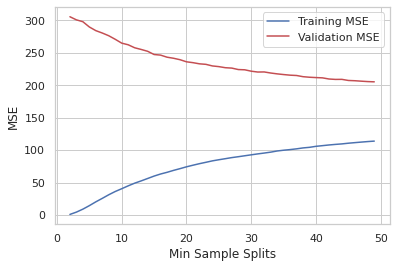

In [ ]:
# Plot the results
import matplotlib.pyplot as plt

plt.plot(min_samples_splits, train_results, 'b',label="Training MSE")
plt.plot(min_samples_splits, val_results,'r',label="Validation MSE")
plt.ylabel("MSE")
plt.xlabel("Min Sample Splits")
plt.legend()
plt.show()

In [ ]:

# Choose the best minimum split sample based on the plot
Best_minSampl = min_samples_splits[np.argmin(val_results)]
print(Best_minSampl)
print("Best Validation MSE = {0}".format(np.min(val_results)))

# Train decision tree using the full training data and the best minimum split sample

x_val_and_train = x_train.append(x_val)
y_val_and_train = y_train.append(y_val)
clf= DecisionTreeRegressor(min_samples_split=Best_minSampl)
  
clf.fit(x_val_and_train,y_val_and_train)

# Estimate the prediction of the test data
test_pred = clf.predict(x_test)

from sklearn.metrics import mean_squared_error
# Calculate accuracy of test data
MSE = mean_squared_error(y_test, test_pred)
print("Mean Squared Error of Test = {0}".format(MSE))


49
Best Validation MSE = 205.15043089978278
Mean Squared Error of Test = 207.24512559499502


**k-NN Model**

Odd k values between 1 and 30 are chosen as hyperparameters in k-NN model and Euclidian distance metric is used. On the validation data, k = 25 gave the minimum MSE. As a result, training is done using this k value and MSE on the test data is found as 201. In order to see the effect of different scales of the features, conversion to scaled versions, substracting mean and dividing by the standard deviation, was neccessary. As expected, MSE value is decreased. This time, k value of 29 gave MSE equal to 180.61.

Best MSE = 196.43523292213953


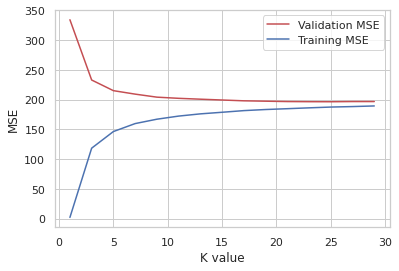

In [ ]:
## K-NN method 
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor

# initialize the values of k to be a list of odd numbers between 1 and 30
kVals = range(1,30,2)


# Save the accuracies of each value of kVal in [accuracies] variable
val_mses = []
train_mses = []

# loop over values of k for the k-Nearest Neighbor classifier
for k in kVals:
  clf_knn= KNeighborsRegressor(n_neighbors=k)
  
  clf_knn.fit(x_train,y_train)
   
  # Evaluate on Validation set
  val_acc = mean_squared_error(clf_knn.predict(x_val), y_val)
  # Evaluate on Training set
  train_acc = mean_squared_error(clf_knn.predict(x_train), y_train)

  val_mses.append(val_acc)
  train_mses.append(train_acc)

print("Best MSE = {0}".format(np.min(val_mses)))
plt.plot(kVals,val_mses,'r',label="Validation MSE")
plt.plot(kVals,train_mses, 'b',label="Training MSE")
plt.ylabel("MSE")
plt.xlabel("K value")
plt.legend()
plt.show()

In [ ]:
# Train k-NN using the full training data with the best K that is found
Best_k = kVals[np.argmin(val_mses)]
print (Best_k)
# Train decision tree using the full training data and the best minimum split sample
clf_knn= KNeighborsRegressor(n_neighbors=Best_k)
  
clf_knn.fit(x_val_and_train,y_val_and_train)

# Testing
# Estimate the prediction of the test data
test_pred = clf_knn.predict(x_test)

from sklearn.metrics import mean_squared_error
# Calculate accuracy of test data
MSE = mean_squared_error(y_test, test_pred)
print("Mean Squared Error of Test = {0}".format(MSE))

25
Mean Squared Error of Test = 201.00674975777855


Best MSE = 180.61028622078663


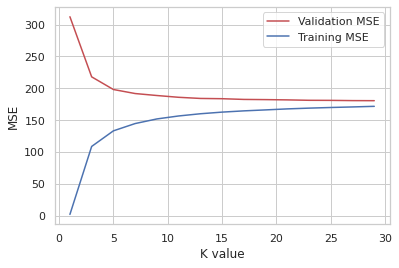

In [ ]:
## K-NN method with scaled features

scaled_x_train = preprocessing.scale(x_train)
scaled_x_val = preprocessing.scale(x_val)
scaled_x_val_and_train = preprocessing.scale(x_val_and_train)
scaled_x_test = preprocessing.scale(x_test)
# initialize the values of k to be a list of odd numbers between 1 and 30
kVals = range(1,30,2)


# Save the accuracies of each value of kVal in [accuracies] variable
val_mses = []
train_mses = []

# loop over values of k for the k-Nearest Neighbor classifier
for k in kVals:
  clf_knn= KNeighborsRegressor(n_neighbors=k)
  
  clf_knn.fit(scaled_x_train,y_train)
   
  # Evaluate on Validation set
  val_acc = mean_squared_error(clf_knn.predict(scaled_x_val), y_val)
  # Evaluate on Training set
  train_acc = mean_squared_error(clf_knn.predict(scaled_x_train), y_train)

  val_mses.append(val_acc)
  train_mses.append(train_acc)


print("Best MSE = {0}".format(np.min(val_mses)))
plt.plot(kVals,val_mses,'r',label="Validation MSE")
plt.plot(kVals,train_mses, 'b',label="Training MSE")
plt.ylabel("MSE")
plt.xlabel("K value")
plt.legend()
plt.show()


In [ ]:
# Train k-NN using the full training data with the best K that is found
Best_k = kVals[np.argmin(val_mses)]
print (Best_k)
# Train decision tree using the full training data and the best minimum split sample
clf_knn= KNeighborsRegressor(n_neighbors=Best_k)
  
clf_knn.fit(scaled_x_val_and_train,y_val_and_train)

# Testing
# Estimate the prediction of the test data
test_pred = clf_knn.predict(scaled_x_test)

from sklearn.metrics import mean_squared_error
# Calculate accuracy of test data
MSE = mean_squared_error(y_test, test_pred)
print("Mean Squared Error of Test = {0}".format(MSE))



29
Mean Squared Error of Test = 183.00743128755084


**Linear Regression Model**

Degrees of polynomials between 1 and 5 are chosen as hyperparameters. Although degree 5 polynomial gave the best MSE result on the validation data, it is very close to MSE value with degree 4 polynomial. Since not much improvement is observed, it is rational to pick polynomial degree as 4 which can be calculated much faster compared to degree 5 polynomial. 

Train Mean squared error of degree 1 polynomial: 233.46490769242502
Validation Mean squared error of degree 1 polynomial: 229.7212818035638

Train Mean squared error of degree 2 polynomial: 202.32973349992812
Validation Mean squared error of degree 2 polynomial: 200.33522939315125

Train Mean squared error of degree 3 polynomial: 182.56027481908941
Validation Mean squared error of degree 3 polynomial: 181.63306837533818

Train Mean squared error of degree 4 polynomial: 176.63470757698815
Validation Mean squared error of degree 4 polynomial: 179.55476968758893

Train Mean squared error of degree 5 polynomial: 175.26554556491078
Validation Mean squared error of degree 5 polynomial: 179.40274525784736



Text(0, 0.5, 'MSE')

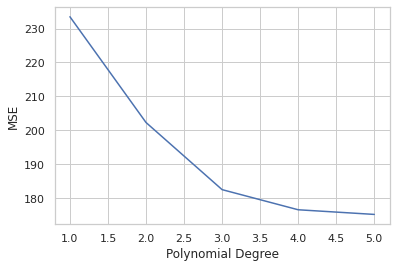

In [ ]:
## Regression
#Polynomial Model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt

arrtrain =[]
arrval = []


degrees = [1,2,3,4,5]
for degree in degrees:
  poly_reg = PolynomialFeatures(degree=degree)
  X_train_poly = poly_reg.fit_transform(x_train)
  X_val_poly = poly_reg.fit_transform(x_val)
  lin_reg = LinearRegression()
  lin_reg.fit(X_train_poly, y_train)
  y_pred_val = lin_reg.predict(X_val_poly)
  y_pred_train = lin_reg.predict(X_train_poly)
  

  #print('Coefficients: \n', lin_reg.coef_)
  #print('Bias:', lin_reg.intercept_)

  # The mean squared error of training
  print("Train Mean squared error of degree "+ str(degree) + " polynomial: " + str(mean_squared_error(y_train, y_pred_train)))
  arrtrain.append(mean_squared_error(y_train, y_pred_train))
  # The mean squared error of validation
  print("Validation Mean squared error of degree "+ str(degree) + " polynomial: " + str(mean_squared_error(y_val, y_pred_val)))
  print("") 
  arrval.append(mean_squared_error(y_val, y_pred_val))

plt.plot(degrees, arrtrain)
plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
#plt.plot(degrees, arrval)

**Comparison of Different Machine Learning Models**

These algorithms spend more time on different parts of these machine learning algorithms. In the decision tree, once the tree is formed with a relatively time-consuming greedy algorithm, it is very easy and fast to make a prediction. The worst case will happen at the deepest level of the tree. We follow a path in the tree, and ask new questions depending on the answers given in the previous questions. It is possible to justify the reason behind the prediction this way. Conversely, it takes less time to train the model compared to the testing in the k-NN model. It stores the data points in the training part, and in testing, it calculates new sample’s pairwise distance to every other training data and sorts. Then, it predicts via majority voting among the top k closest neighbors. In terms of memory, k-NN requires more space it has to remember every single point in the data. In the regression model, training time increases with respect to polynomial degree. Moreover, the model becomes prone to overfit as polynomial degree increases. They are both commonly used in the research and industry and it is important to understand their biases before using them.

**Results**

Scaled k-NN model and polynomial regression model gave similar results when the best hyperparameters are used. These results are better than k-NN with unscaled features and decision tree.

**Song Recommendation System**

Euclidean distances are used in this recommendation system which is based on the k-NN algorithm. 10 random songs are selected among all songs and they are treated as the top loved songs of a person. Then, their numeric features' distances are calculated between all other songs and 2 most similar ones are returned for each one. 

To see the effectiveness of the algorithm, one song is selected and its 5 closest neighbors are returned. It is observed that they have similar features.

In [ ]:
#Load the dataset
from sklearn.cluster import KMeans 
from tqdm import tqdm
from tqdm import tqdm
from sklearn.cluster import KMeans 
import math
dfnew = df
#reference: https://github.com/sunkusowmyasree/Spotify_Capstone_Project/blob/main/Song_Recommender.ipynb
dfnew.pop('popularity')

namesoflovedsongs = []

lovedsongs =dfnew.sample(10)
for song in range(len(lovedsongs)) :
  namesoflovedsongs .append(df.loc[song, "name"])


def normalize_column(col):

    max_d = dfnew[col].max()
    min_d = dfnew[col].min()
    dfnew[col] = (dfnew[col] - min_d)/(max_d - min_d)
    
#Normalize allnumerical columns so that min value is 0 and max value is 1
num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = dfnew.select_dtypes(include=num_types)
        
for col in num.columns:
    normalize_column(col)
    
#perform Kmeans CLustering
km = KMeans(n_clusters=25)
pred = km.fit_predict(num)
dfnew['pred'] = pred
normalize_column('pred')

#Song Recommender
class Song_Recommender():
    """
    Neighbourhood Based Collborative Filterng REcoomendation System using similarity Metrics
   Euclidian Distance is calculated for all songs and Recommend Songs that are similar to it based on any given songs
    """
    def __init__(self, data):
        self.data_ = data
    
    #function which returns recommendations
    def get_recommendations(self, song_name, n_top):
        distances = []
        #choosing the given song_name and dropping it from the data
        song = self.data_[(self.data_.name.str.lower() == song_name.lower())].head(1).values[0]
        
        rem_data = self.data_[self.data_.name.str.lower() != song_name.lower()]
      
        for r_song in tqdm(rem_data.values):
            dist = 0
            #numeric_variables = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo", "valence", "popularity", "year"]
            # all_variables = dfnew.columns

            for col in np.arange(len(rem_data.columns)):
                #indeces of non-numerical columns(id,explicit,popularity,release_date, songname,artist)
                if not col in [1,5,6,8,12,13]:
          
                  dist = dist + (float(song[col]) - float(r_song[col]))**2
                
            distances.append(math.sqrt(dist))
        rem_data['distance'] = distances
        #sorting our data to be ascending by 'distance' feature
        rem_data = rem_data.sort_values('distance')
        columns = ['artists', 'name']
        return rem_data[columns][:n_top]


#Instantiate recommender class
recommender = Song_Recommender(dfnew)

#Get recommendations 'Red Roses (feat. Landon Cube)' song
for lovedsong in namesoflovedsongs :
  print (recommender.get_recommendations(lovedsong, 2))



100%|██████████| 174387/174387 [00:09<00:00, 19125.15it/s]


                            artists                                               name
21961  Billie Holiday, Teddy Wilson  If Dreams Come True (with Teddy Wilson & His O...
22078                 Carlos Gardel                                    De Flor En Flor


100%|██████████| 174378/174378 [00:08<00:00, 20277.20it/s]


                                  artists                           name
914     Tommy Dorsey & His Clambake Seven           Vol Vistu Gaily Star
158900                       Sir Lancelot  The Century of the Common Man


100%|██████████| 174388/174388 [00:08<00:00, 19620.71it/s]


              artists                   name
173       Mamie Smith  The Lure Of The South
1629  Agustin Magaldi    Portero Suba y Diga


100%|██████████| 174388/174388 [00:10<00:00, 17210.65it/s]


                 artists                          name
20954  Shungi Music Crew                     The Storm
9                 Meetya  Broken Puppet - Original Mix


100%|██████████| 174388/174388 [00:09<00:00, 19366.25it/s]


         artists               name
20312        696  Wanna Make a Wish
20276  Rome No.9         Hey Lookie


100%|██████████| 174388/174388 [00:09<00:00, 18692.60it/s]


                                                 artists                                               name
20363                                       FPS Allstars  Turbo OutRun Theme (From "Turbo Outrun") [Gene...
1439   Orchestre Piero Coppola, Ch&#339;ur Piero Copp...  Carmen : Acte IV - Voici le quadrille (Marche ...


100%|██████████| 174388/174388 [00:09<00:00, 18728.53it/s]


          artists                    name
516  Bessie Smith  Empty Bed Blues, Pt. 2
485  Bessie Smith           Me and My Gin


100%|██████████| 174388/174388 [00:08<00:00, 20695.39it/s]


                                                artists                                        name
2319                                         Val Rosing                     Try A Little Tenderness
674   Hoagy Carmichael & His Orchestra, Bix Beiderbecke  Georgia On My Mind (feat. Bix Beiderbecke)


100%|██████████| 174388/174388 [00:08<00:00, 20179.57it/s]


              artists                         name
198  Francisco Canaro  El Huerfano - Remasterizado
578   Ignacio Corsini    La Payasa - Remasterizado


100%|██████████| 174388/174388 [00:10<00:00, 17305.00it/s]


            artists                                               name
24  Oscar Velazquez            True House Music - Original Massive Mix
3   Oscar Velazquez  True House Music - Xavier Santos & Carlos Gomi...


In [ ]:
namesoflovedsongs

['Keep A Song In Your Soul',
 'I Put A Spell On You',
 'Golfing Papa',
 'True House Music - Xavier Santos & Carlos Gomix Remix',
 'Xuniverxe',
 'Crazy Blues - 78rpm Version',
 "Don't You Advertise Your Man",
 'Arkansas Blues',
 'La Chacarera - Remasterizado',
 'Broken Puppet - Original Mix']

In [ ]:
#Load the dataset
from tqdm import tqdm
from sklearn.cluster import KMeans 
from sklearn.cluster import KMeans 
from tqdm import tqdm
import math
dfnew = df
#reference: https://github.com/sunkusowmyasree/Spotify_Capstone_Project/blob/main/Song_Recommender.ipynb
#dfnew.pop('popularity')


def normalize_column(col):

    max_d = dfnew[col].max()
    min_d = dfnew[col].min()
    dfnew[col] = (dfnew[col] - min_d)/(max_d - min_d)
    
#Normalize allnumerical columns so that min value is 0 and max value is 1
num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = dfnew.select_dtypes(include=num_types)
        
for col in num.columns:
    normalize_column(col)
    
#perform Kmeans CLustering
km = KMeans(n_clusters=25)
pred = km.fit_predict(num)
dfnew['pred'] = pred
normalize_column('pred')

#Song Recommender
class Song_Recommender():
 
    def __init__(self, data):
        self.data_ = data
    
    #function which returns recommendations
    def get_recommendations(self, song_name, n_top):
        distances = []
        #choosing the given song_name and dropping it from the data
        song = self.data_[(self.data_.name.str.lower() == song_name.lower())].head(1).values[0]
        
        rem_data = self.data_[self.data_.name.str.lower() != song_name.lower()]
      
        for r_song in tqdm(rem_data.values):
            dist = 0
            #numeric_variables = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo", "valence", "popularity", "year"]
            for col in np.arange(len(rem_data.columns)):
                #indeces of non-numerical columns(id,explicit,popularity,release_date, songname,artist)
                if not col in [1,5,6,8,12,13]:
          
                  dist = dist + (float(song[col]) - float(r_song[col]))**2
                
            distances.append(math.sqrt(dist))
        rem_data['distance'] = distances
        #sorting our data to be ascending by 'distance' feature
        rem_data = rem_data.sort_values('distance')
        columns = ['artists', 'name']
        return rem_data[columns][:n_top]


#form recommender class
recommender = Song_Recommender(dfnew)

#Get recommendations 'Red Roses (feat. Landon Cube)' song
recommender.get_recommendations('Red Roses (feat. Landon Cube)', 5)

100%|██████████| 174388/174388 [00:09<00:00, 19365.20it/s]


,artists,name
18878,Melanie Martinez,Play Date
109626,Post Malone,"Yours Truly, Austin Post"
19576,"Post Malone, Ty Dolla $ign",Psycho (feat. Ty Dolla $ign)
93550,"Vince Staples, 6LACK, Mereba","Yo Love - From ""Queen & Slim: The Soundtrack"""
39093,Zara Larsson,Ruin My Life
